<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/Final%20Version/DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def fit_and_evaluate(model, X_train, y_train, X_test, y_test):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

# Data Reading for ML models

In [4]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


#X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

NameError: name 'data_array' is not defined

In [ ]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
#y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

# Extract 6 Features using DT for ML model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.01)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    #X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    #print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected
X_trainD, X_testD = select_features_with_decision_tree(X_train, y_train, X_test, y_test)
print(X_trainD.shape)
print(X_testD.shape)
#print(X_valD.shape)

[[-4.02052319 -3.92122071 -4.19766329 -4.14916175 -4.19766329 -3.92122071]
 [-4.02052319 -3.92122071 -4.19766329 -4.14916175 -4.19766329 -3.92122071]
 [-4.02052319 -3.92122071  0.18658284  0.1705135   0.18658284  0.18930031]
 ...
 [-0.15129016 -0.17531763 -0.12309218 -0.08673444 -0.15129016  5.46867382]
 [-0.15129016 -0.17531763 -0.12309218 -0.08673444 -0.15129016 -0.19671489]
 [-0.15129016 -0.17531763  8.73954447 -0.08673444 -0.15129016 -0.19671489]]
[[ 1.27029686e+01 -1.47669020e-01 -3.20702906e-13 -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 [-8.47280843e-02 -1.47669020e-01 -3.20702906e-13 -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 [-8.47280843e-02 -1.47669020e-01 -3.20702906e-13 -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 ...
 [-8.61778652e-02 -8.61341994e-02 -1.22234380e-01 -1.95253142e-01
  -1.50228465e-01 -3.20702906e-13]
 [-8.61778652e-02 -8.61341994e-02 -1.22234380e-01 -1.95253142e-01
  -1.50228465e-01 -3.20702906e-13]
 [-8.61778652e-02 -8.61341994e-02 

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_trainML6.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_testML6.npy', X_testD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_trainML6.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_testML6.npy', y_test)

# Extract 9 Features using DT for ML model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.001)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    #X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    #print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected
X_trainD, X_testD = select_features_with_decision_tree(X_train, y_train, X_test, y_test)
print(X_trainD.shape)
print(X_testD.shape)
#print(X_valD.shape)

[[-3.96922556 -3.92122071 -3.92122071 ... -4.14916175 -4.19766329
  -3.92122071]
 [-3.96922556 -3.92122071 -3.92122071 ... -4.14916175 -4.19766329
  -3.92122071]
 [-3.96922556 -3.92122071 -3.92122071 ...  0.1705135   0.18658284
   0.18930031]
 ...
 [-0.08673444 -0.15129016 -0.17531763 ... -0.08673444 -0.15129016
   5.46867382]
 [-0.08673444 -0.15129016 -0.17531763 ... -0.08673444 -0.15129016
  -0.19671489]
 [-0.08673444 -0.15129016 -0.17531763 ... -0.08673444 -0.15129016
  -0.19671489]]
[[ 1.27029686e+01  1.27029676e+01 -1.47669020e-01 ... -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 [-8.47280843e-02 -8.16685062e-02 -1.47669020e-01 ... -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 [-8.47280843e-02 -8.47905174e-02 -1.47669020e-01 ... -1.20165967e-01
  -8.46864627e-02 -3.20702906e-13]
 ...
 [-8.62625521e-02 -8.62202085e-02 -8.61341994e-02 ... -1.95253142e-01
  -1.50228465e-01 -3.20702906e-13]
 [-8.62625521e-02 -8.62202085e-02 -8.61341994e-02 ... -1.95253142e-01
  -1.50228465

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_trainML9.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_testML9.npy', X_testD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_trainML9.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_testML9.npy', y_test)

# Extract 9 Features using DT for ML model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.00001)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    #X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    #print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected
X_trainD, X_testD = select_features_with_decision_tree(X_train, y_train, X_test, y_test)
print(X_trainD.shape)
print(X_testD.shape)
#print(X_valD.shape)

[[-3.87029088 -3.92122071 -4.40043768 ... -4.19766329 -4.02052319
  -3.92122071]
 [-3.87029088 -3.92122071 -4.40043768 ... -4.19766329 -4.02052319
  -3.92122071]
 [-3.87029088 -3.92122071  0.24446876 ...  0.18658284  0.2233624
   0.18930031]
 ...
 [-0.08677709 -0.17531763 -0.15129016 ... -0.15129016 -0.12309218
   5.46867382]
 [-0.08677709 -0.17531763 -0.15129016 ... -0.15129016 -0.12309218
  -0.19671489]
 [-0.08677709 -0.17531763 -0.15129016 ... -0.15129016 -0.12309218
  -0.19671489]]
[[ 1.27029694e+01 -1.47669020e-01 -1.20165967e-01 ... -8.46864627e-02
  -3.20702906e-13 -3.20702906e-13]
 [-8.46864627e-02 -1.47669020e-01 -1.20165967e-01 ... -8.46864627e-02
  -3.20702906e-13 -3.20702906e-13]
 [-8.46864627e-02 -1.47669020e-01 -1.20165967e-01 ... -8.46864627e-02
  -3.20702906e-13 -3.20702906e-13]
 ...
 [-8.61765422e-02 -8.61341994e-02 -1.22177518e-01 ... -1.50228465e-01
  -1.74015115e-01 -3.20702906e-13]
 [-8.61765422e-02 -8.61341994e-02 -1.22177518e-01 ... -1.50228465e-01
  -1.74015115e

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_trainML10.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_testML10.npy', X_testD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_trainML10.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_testML10.npy', y_test)

# ML models

## DT6

In [5]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_trainML6.npy')
X_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_testML6.npy')
y_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_trainML6.npy')
y_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_testML6.npy')

### KNN

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.5661605206073753
Recall: 0.5661605206073753
Precision: 0.5741206472559401
F1-score: 0.5699037229751251
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.32      0.34      0.33       435
           1       0.69      0.67      0.68       948

    accuracy                           0.57      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.57      0.57      0.57      1383



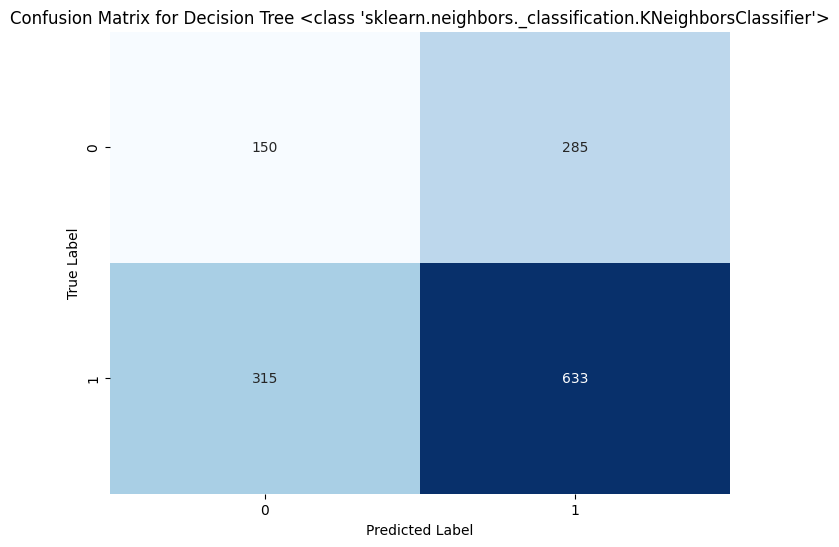

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

model=fit_and_evaluate(KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'),X_train, y_train,X_test , y_test)


### RF

<ipython-input-202-cfc135d9a6f7>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy: 0.6811279826464208
Recall: 0.6811279826464208
Precision: 0.7094519689015186
F1-score: 0.6899043846120074
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.64      0.56       435
           1       0.81      0.70      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      1383
weighted avg       0.71      0.68      0.69      1383



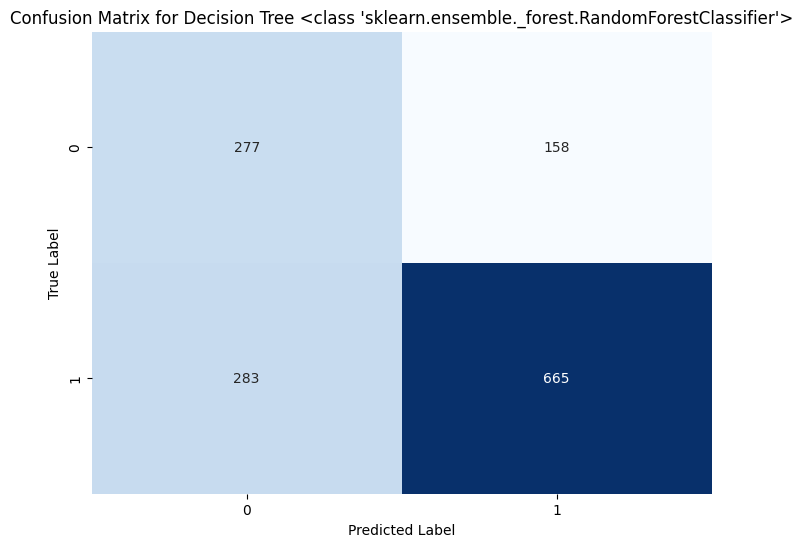

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RF
model=fit_and_evaluate(RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 ),X_train, y_train,X_test , y_test)


### DT

Accuracy: 0.6789587852494577
Recall: 0.6789587852494577
Precision: 0.7102521333366694
F1-score: 0.6882555191430787
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       435
           1       0.81      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      1383
weighted avg       0.71      0.68      0.69      1383



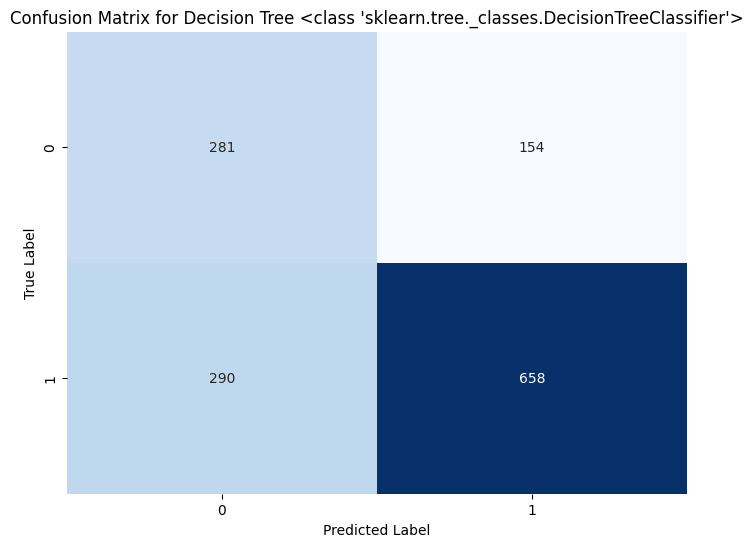

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# DT
tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(**tree_params)
model=fit_and_evaluate(dt_classifier,X_train, y_train,X_test , y_test)



### XGboost


Accuracy: 0.6890817064352857
Recall: 0.6890817064352857
Precision: 0.718428161933634
F1-score: 0.6978476304650632
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.66      0.57       435
           1       0.82      0.70      0.76       948

    accuracy                           0.69      1383
   macro avg       0.66      0.68      0.66      1383
weighted avg       0.72      0.69      0.70      1383



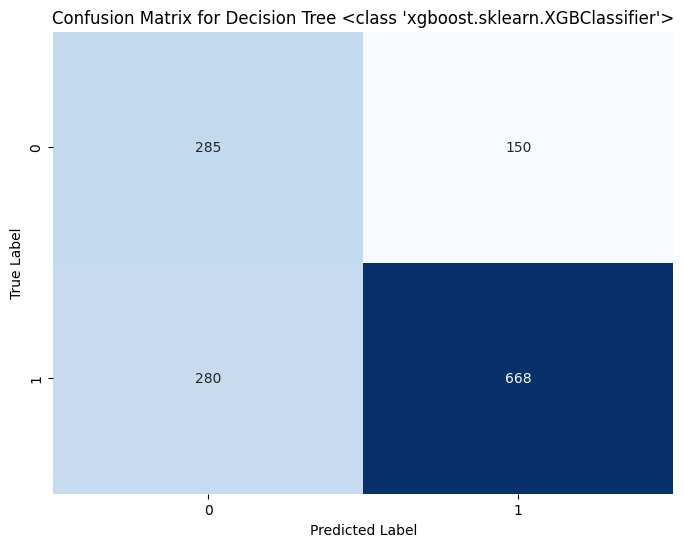

In [ ]:
from xgboost import XGBClassifier

# Train a Decision Tree Classifier
xgb_classifier = XGBClassifier(
    max_depth=9,
    n_estimators=200,
    learning_rate=0.01
)
model=fit_and_evaluate(xgb_classifier,X_train, y_train,X_test , y_test)


### Adaboost


In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model=fit_and_evaluate(AdaBoostClassifier(n_estimators=200, learning_rate = 1),
                       X_train, y_train,X_test , y_test)

### LightGBM

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.6818510484454086
Recall: 0.6818510484454086
Precision: 0.7141132296762639
F1-score: 0.6912185004911136
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.66      0.56       435
           1       0.81      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.66      0.67      0.66      1383
weighted avg       0

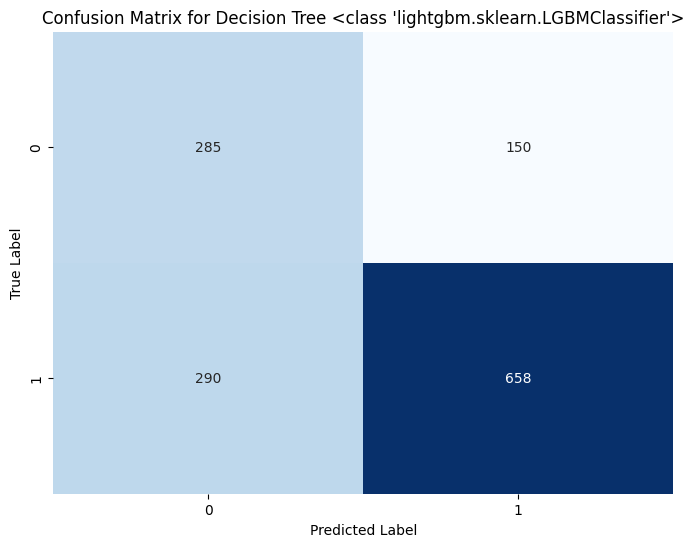

In [6]:
from lightgbm import LGBMClassifier
model=fit_and_evaluate(LGBMClassifier(learning_rate = 0.01, n_estimators = 200,max_depth = -1,
                                      subsample = 0.8, colsample_bytree = 0.8), X_train, y_train,X_test , y_test)

### Bernoulli NB

Accuracy: 0.6854663774403471
Recall: 0.6854663774403471
Precision: 0.46986415460119235
F1-score: 0.5575479414958807
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       435
           1       0.69      1.00      0.81       948

    accuracy                           0.69      1383
   macro avg       0.34      0.50      0.41      1383
weighted avg       0.47      0.69      0.56      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score

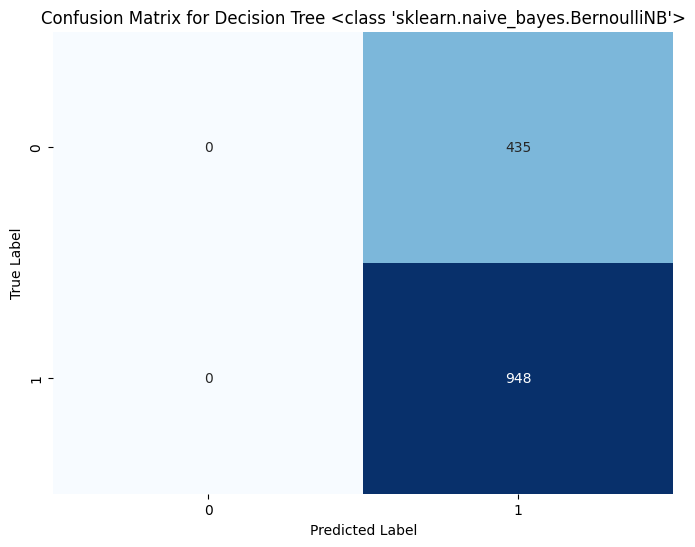

In [7]:
from sklearn.naive_bayes import BernoulliNB
model=fit_and_evaluate(BernoulliNB(alpha = 0.1, binarize = 0.0, fit_prior = True),
                       X_train, y_train,X_test , y_test)

### Gaussian NB

Accuracy: 0.6673897324656544
Recall: 0.6673897324656544
Precision: 0.5738161564943338
F1-score: 0.5755428065386756
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.33      0.06      0.09       435
           1       0.69      0.95      0.80       948

    accuracy                           0.67      1383
   macro avg       0.51      0.50      0.45      1383
weighted avg       0.57      0.67      0.58      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


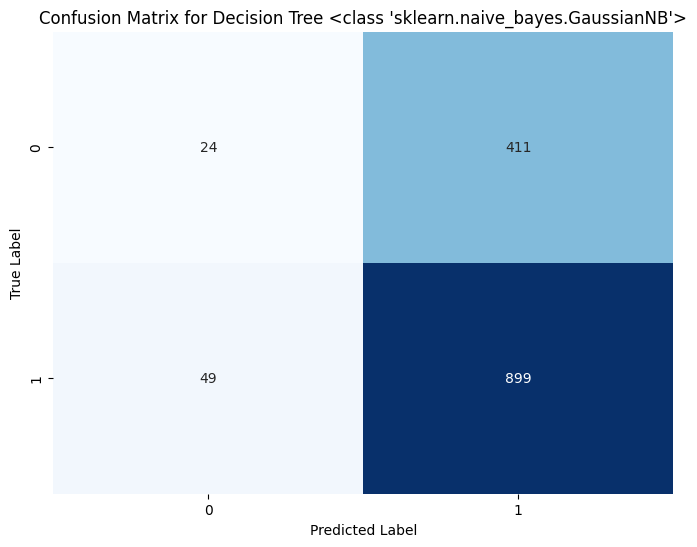

In [8]:
from sklearn.naive_bayes import GaussianNB
model=fit_and_evaluate(GaussianNB(), X_train, y_train,X_test , y_test)

## DT9


In [9]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_trainML9.npy')
X_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_testML9.npy')
y_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_trainML9.npy')
y_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_testML9.npy')

### KNN

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.5762834417932032
Recall: 0.5762834417932032
Precision: 0.5794268680101929
F1-score: 0.5778164515687683
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.33      0.34      0.34       435
           1       0.69      0.68      0.69       948

    accuracy                           0.58      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.58      0.58      0.58      1383



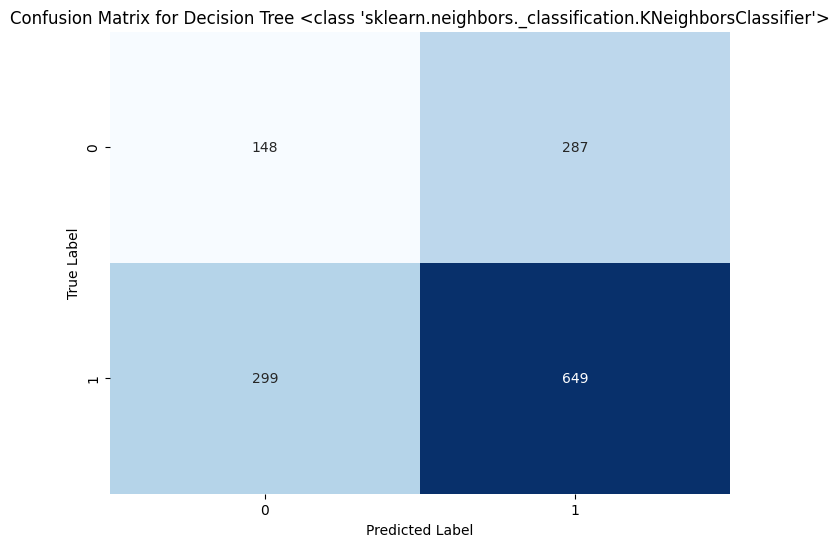

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model=fit_and_evaluate(KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'),X_train, y_train,X_test , y_test)


### RF (BEST)

<ipython-input-202-cfc135d9a6f7>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy: 0.7881417208966016
Recall: 0.7881417208966016
Precision: 0.7872456192285334
F1-score: 0.7876721542515491
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.67      0.66      0.66       435
           1       0.84      0.85      0.85       948

    accuracy                           0.79      1383
   macro avg       0.75      0.75      0.75      1383
weighted avg       0.79      0.79      0.79      1383



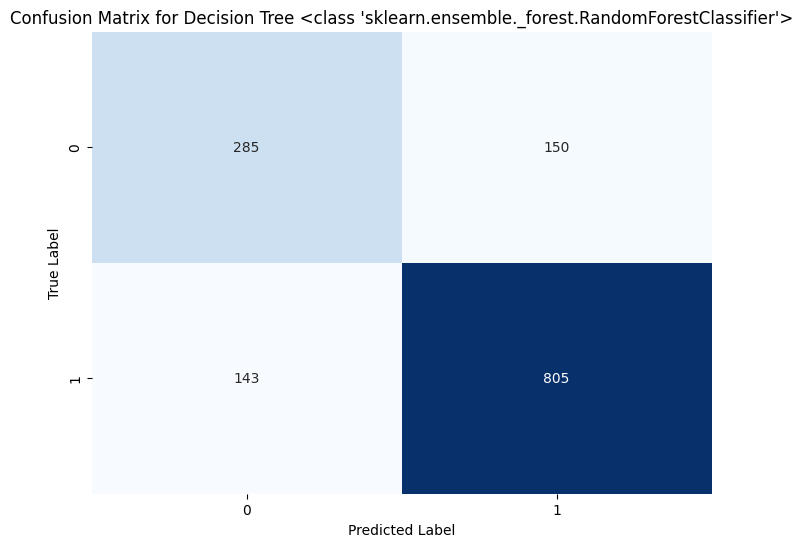

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# RF (BEST)
model=fit_and_evaluate(RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 ),X_train, y_train,X_test , y_test)


### DT

Accuracy: 0.6789587852494577
Recall: 0.6789587852494577
Precision: 0.7102521333366694
F1-score: 0.6882555191430787
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       435
           1       0.81      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      1383
weighted avg       0.71      0.68      0.69      1383



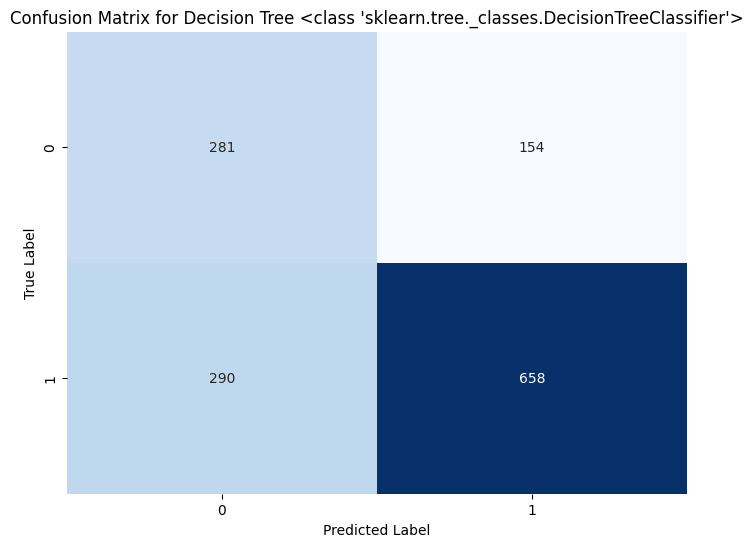

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(**tree_params)
model=fit_and_evaluate(dt_classifier,X_train, y_train,X_test , y_test)



### XGboost

Accuracy: 0.6789587852494577
Recall: 0.6789587852494577
Precision: 0.7124031087076392
F1-score: 0.6885611365701151
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.66      0.56       435
           1       0.81      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      1383
weighted avg       0.71      0.68      0.69      1383



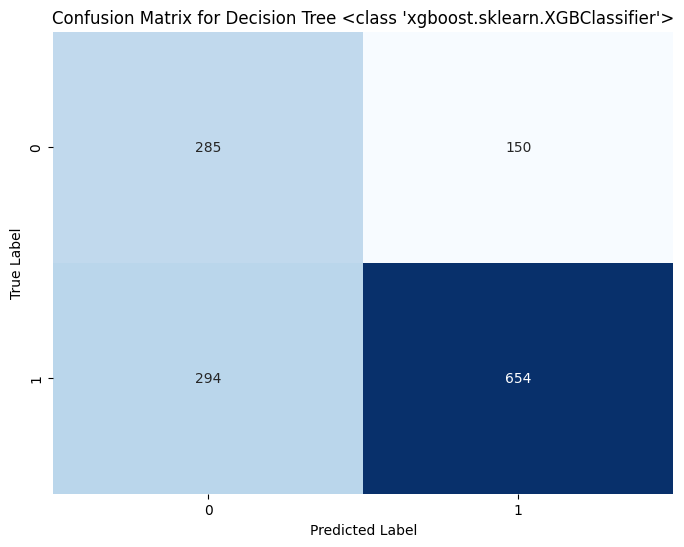

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Train a Decision Tree Classifier
xgb_classifier = XGBClassifier(
    max_depth=9,
    n_estimators=200,
    learning_rate=0.01
)
model=fit_and_evaluate(xgb_classifier,X_train, y_train,X_test , y_test)


### Adaboost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6023138105567607
Recall: 0.6023138105567607
Precision: 0.6683885281625886
F1-score: 0.6164991278113772
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.42      0.65      0.51       435
           1       0.78      0.58      0.67       948

    accuracy                           0.60      1383
   macro avg       0.60      0.62      0.59      1383
weighted avg       0.67      0.60      0.62      1383



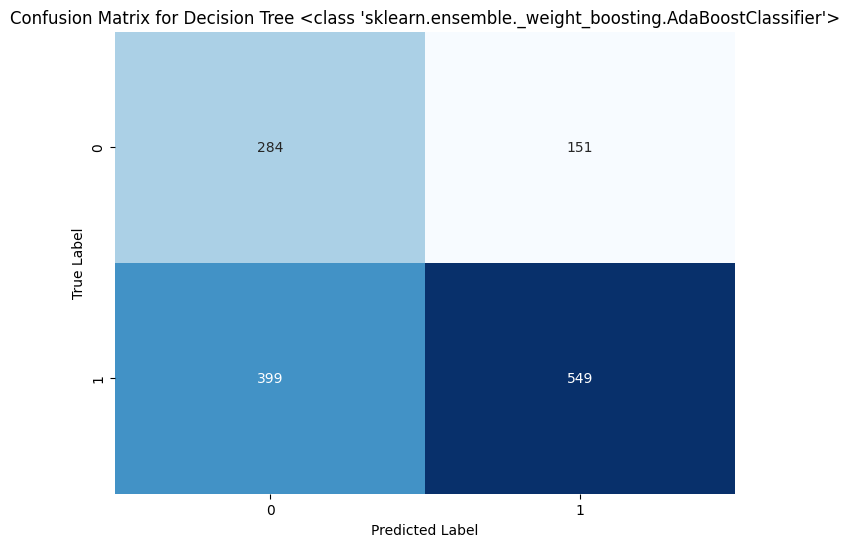

In [10]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model=fit_and_evaluate(AdaBoostClassifier(n_estimators=200, learning_rate = 1),
                       X_train, y_train,X_test , y_test)

### LightGBM

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.6789587852494577
Recall: 0.6789587852494577
Precision: 0.7124031087076392
F1-score: 0.6885611365701151
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.66      0.56       435
           1       0.81      0.69

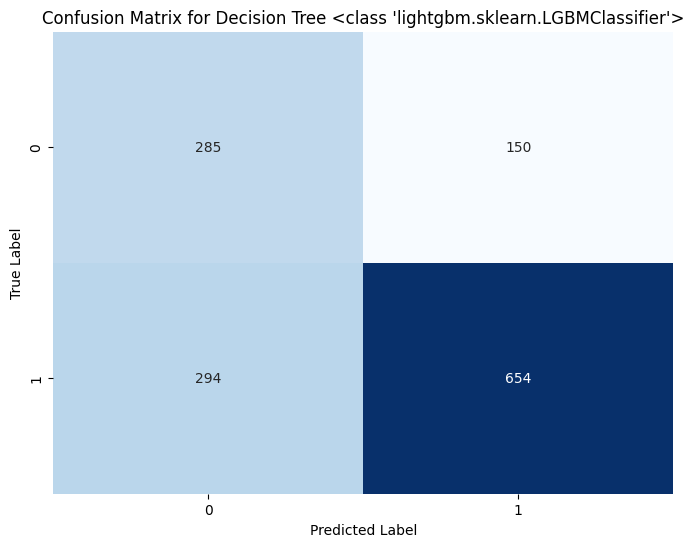

In [11]:
from lightgbm import LGBMClassifier
model=fit_and_evaluate(LGBMClassifier(learning_rate = 0.01, n_estimators = 200,max_depth = -1,
                                      subsample = 0.8, colsample_bytree = 0.8), X_train, y_train,X_test , y_test)

### Bernoulli NB

Accuracy: 0.36225596529284165
Recall: 0.36225596529284165
Precision: 0.5917117257319824
F1-score: 0.28386279536464554
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.32      0.90      0.47       435
           1       0.72      0.11      0.20       948

    accuracy                           0.36      1383
   macro avg       0.52      0.51      0.33      1383
weighted avg       0.59      0.36      0.28      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


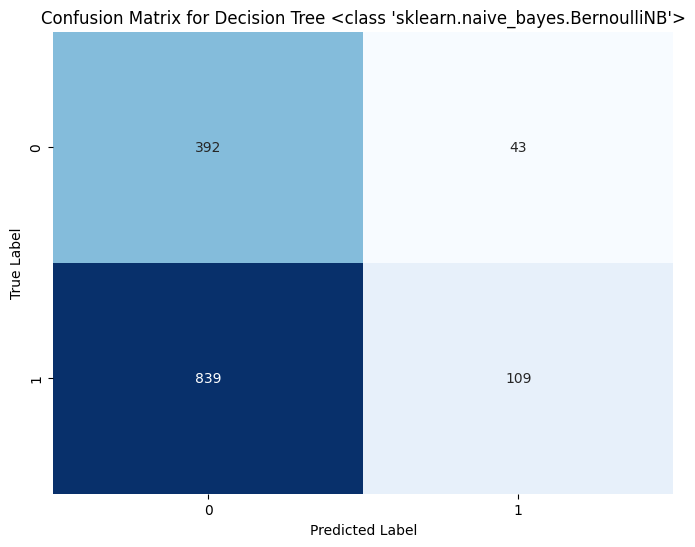

In [12]:
from sklearn.naive_bayes import BernoulliNB
model=fit_and_evaluate(BernoulliNB(alpha = 0.1, binarize = 0.0, fit_prior = True),
                       X_train, y_train,X_test , y_test)

### Gaussian NB

Accuracy: 0.6558206796818511
Recall: 0.6558206796818511
Precision: 0.557724831743605
F1-score: 0.5715910188330733
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.28      0.06      0.10       435
           1       0.68      0.93      0.79       948

    accuracy                           0.66      1383
   macro avg       0.48      0.50      0.44      1383
weighted avg       0.56      0.66      0.57      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


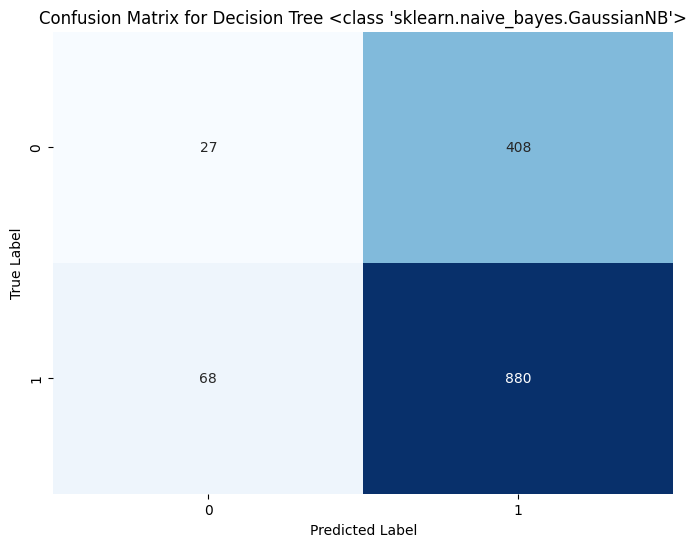

In [13]:
from sklearn.naive_bayes import GaussianNB
model=fit_and_evaluate(GaussianNB(), X_train, y_train,X_test , y_test)

## DT 10

In [15]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_trainML10.npy')
X_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_testML10.npy')
y_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_trainML10.npy')
y_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_testML10.npy')

### KNN (BEST)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.7664497469269703
Recall: 0.7664497469269703
Precision: 0.7646673642513501
F1-score: 0.739636447509959
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.38      0.51       435
           1       0.77      0.94      0.85       948

    accuracy                           0.77      1383
   macro avg       0.76      0.66      0.68      1383
weighted avg       0.76      0.77      0.74      1383



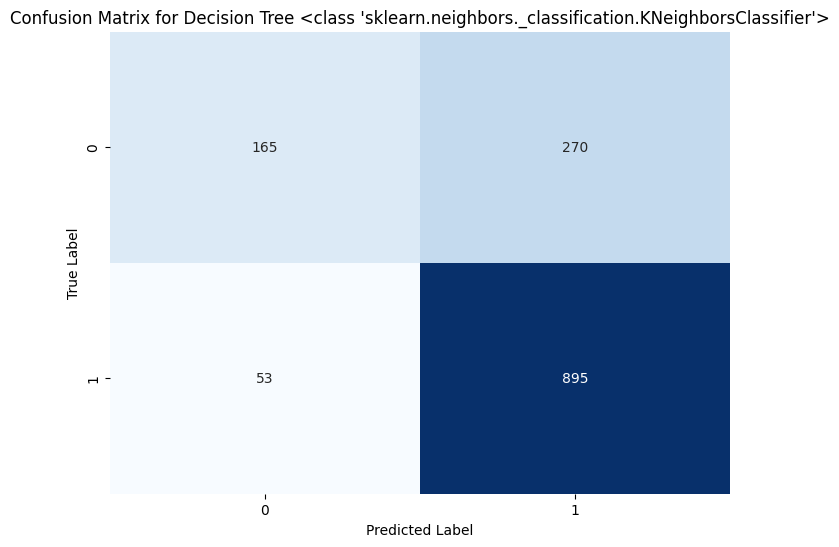

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# KNN (BEST)
model=fit_and_evaluate(KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'),X_train, y_train,X_test , y_test)


### RF (BEST)

<ipython-input-202-cfc135d9a6f7>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy: 0.6861894432393347
Recall: 0.6861894432393347
Precision: 0.7151145310476773
F1-score: 0.6949539089564963
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.65      0.57       435
           1       0.81      0.70      0.75       948

    accuracy                           0.69      1383
   macro avg       0.66      0.68      0.66      1383
weighted avg       0.72      0.69      0.69      1383



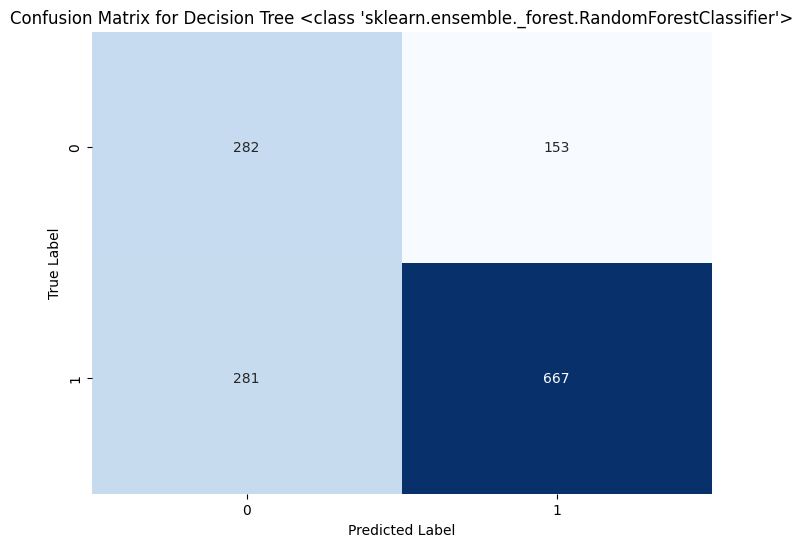

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# RF (BEST)
model=fit_and_evaluate(RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 ),X_train, y_train,X_test , y_test)


### DT

Accuracy: 0.6789587852494577
Recall: 0.6789587852494577
Precision: 0.7102521333366694
F1-score: 0.6882555191430787
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       435
           1       0.81      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.65      1383
weighted avg       0.71      0.68      0.69      1383



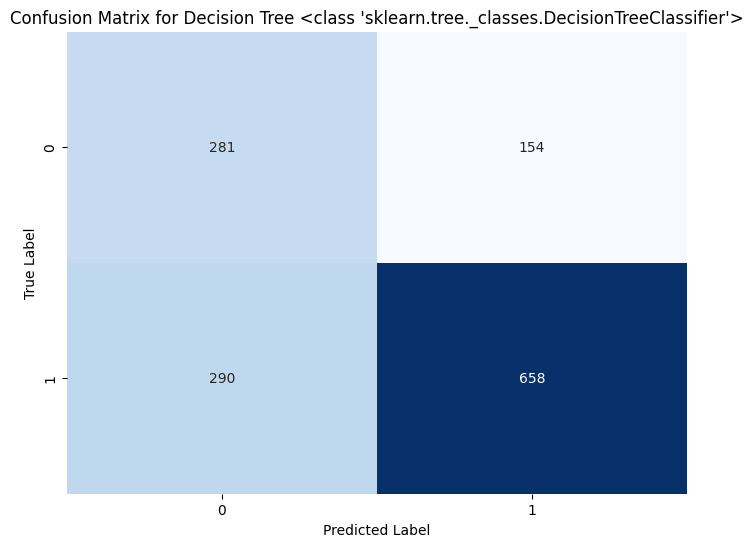

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(**tree_params)
model=fit_and_evaluate(dt_classifier,X_train, y_train,X_test , y_test)



### XGboost (BEST)


Accuracy: 0.6847433116413594
Recall: 0.6847433116413594
Precision: 0.7179863330442972
F1-score: 0.6941726476229058
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.66      0.57       435
           1       0.82      0.69      0.75       948

    accuracy                           0.68      1383
   macro avg       0.66      0.68      0.66      1383
weighted avg       0.72      0.68      0.69      1383



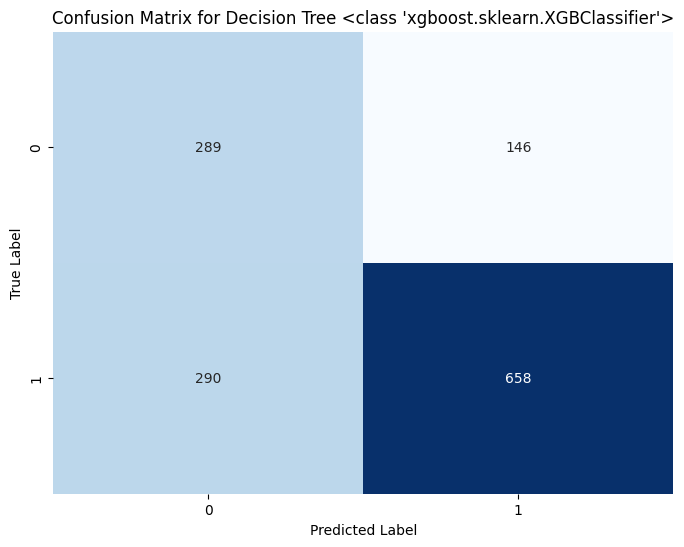

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Train a Decision Tree Classifier
xgb_classifier = XGBClassifier(
    max_depth=9,
    n_estimators=200,
    learning_rate=0.01
)
model=fit_and_evaluate(xgb_classifier,X_train, y_train,X_test , y_test)


### Adaboost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6883586406362979
Recall: 0.6883586406362979
Precision: 0.7164247421042307
F1-score: 0.6969360312194448
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.65      0.57       435
           1       0.81      0.71      0.76       948

    accuracy                           0.69      1383
   macro avg       0.66      0.68      0.66      1383
weighted avg       0.72      0.69      0.70      1383



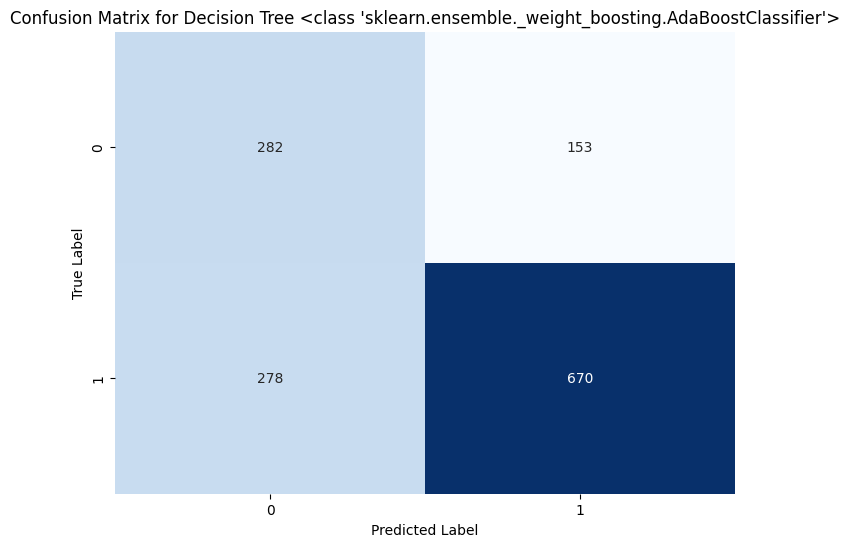

In [16]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model=fit_and_evaluate(AdaBoostClassifier(n_estimators=200, learning_rate = 1),
                       X_train, y_train,X_test , y_test)

### LightGBM

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
Accuracy: 0.6818510484454086
Recall: 0.6818510484454086
Precision: 0.7119813780738455
F1-score: 0.6909034352090602
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.65      0.56       435
           1       0.81      0.70      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.66      1383
weighted avg       0.71      0.68      0.69      1383



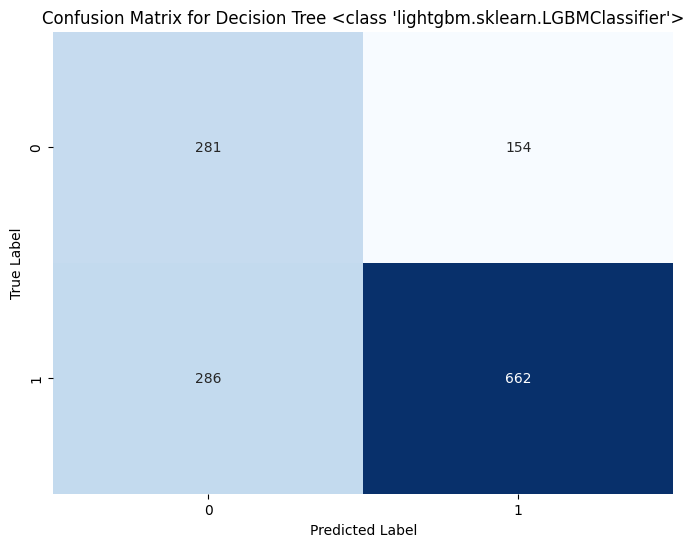

In [17]:
from lightgbm import LGBMClassifier
model=fit_and_evaluate(LGBMClassifier(learning_rate = 0.01, n_estimators = 200,max_depth = -1,
                                      subsample = 0.8, colsample_bytree = 0.8), X_train, y_train,X_test , y_test)

### Bernoulli NB

Accuracy: 0.4822848879248012
Recall: 0.4822848879248012
Precision: 0.5311737531205105
F1-score: 0.4994312191666611
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.27      0.38      0.32       435
           1       0.65      0.53      0.58       948

    accuracy                           0.48      1383
   macro avg       0.46      0.46      0.45      1383
weighted avg       0.53      0.48      0.50      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


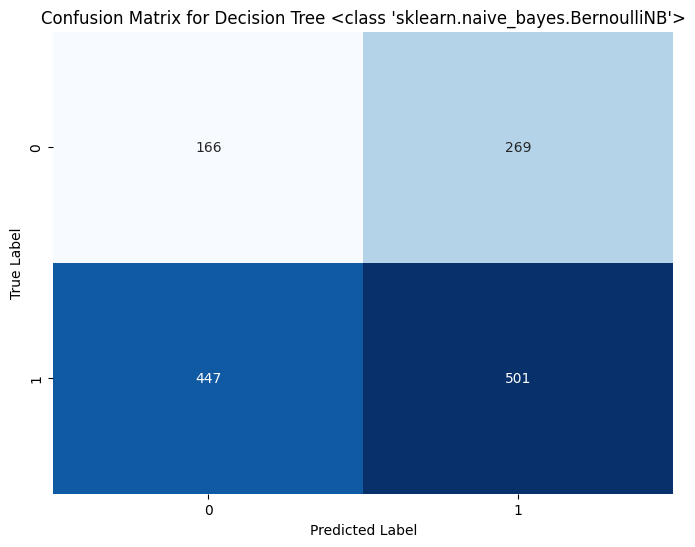

In [18]:
from sklearn.naive_bayes import BernoulliNB
model=fit_and_evaluate(BernoulliNB(alpha = 0.1, binarize = 0.0, fit_prior = True),
                       X_train, y_train,X_test , y_test)

### Gaussian NB

Accuracy: 0.6724511930585684
Recall: 0.6724511930585684
Precision: 0.5792330045430361
F1-score: 0.5743755817567809
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.34      0.05      0.08       435
           1       0.69      0.96      0.80       948

    accuracy                           0.67      1383
   macro avg       0.52      0.50      0.44      1383
weighted avg       0.58      0.67      0.57      1383



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


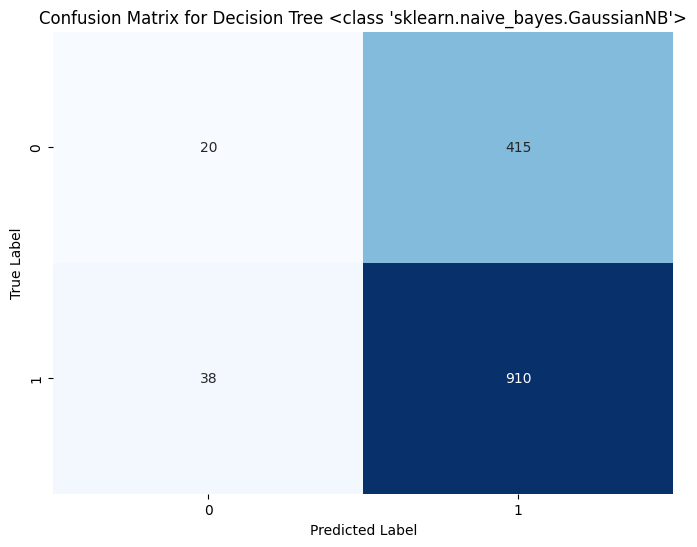

In [19]:
from sklearn.naive_bayes import GaussianNB
model=fit_and_evaluate(GaussianNB(), X_train, y_train,X_test , y_test)

# Extract 5 Features using DT for DL model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.01)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected, X_val_selected
X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
print(X_trainD.shape)
print(X_testD.shape)
print(X_valD.shape)

[[-3.92122071 -4.02052319 -3.90876296 -4.07543816 -4.20539541]
 [-3.92122071 -4.02052319 -3.90876296 -4.07543816 -4.20539541]
 [-3.92122071 -4.02052319 -3.90876296 -4.07543816  0.1878699 ]
 ...
 [-0.17531763 -0.08673444 -0.17525365 -0.08673444 -0.15129016]
 [-0.17531763 -0.08673444 -0.17525365 -0.08673444 -0.15129016]
 [-0.17531763 -0.08673444 -0.17525365 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02
  -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02
  -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02
  -8.46864627e-02]
 ...
 [-8.61341994e-02 -8.61341994e-02 -1.22234380e-01 -3.20702906e-13
  -1.50228465e-01]
 [-8.61341994e-02 -8.61341994e-02 -1.22234380e-01 -3.20702906e-13
  -1.50228465e-01]
 [-8.61341994e-02 -8.61341994e-02 -1.22234380e-01 -3.20702906e-13
  -1.50228465e-01]]
[[-1.22661028e-01 -3.20702906e-13 -1.22661028e-01 -1.74631087e-01
  -1.22661028e-01]
 [-1.22661028e-

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy', X_valD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy', X_testD)

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy', y_val)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy', y_test)

# Extract 7 Features using DT for DL model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.001)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected, X_val_selected

In [ ]:
X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)


[[-4.07543816 -3.92122071 -4.02052319 ... -4.07543816 -4.33056319
  -4.20539541]
 [-4.07543816 -3.92122071 -4.02052319 ... -4.07543816 -4.33056319
  -4.20539541]
 [-4.07543816 -3.92122071 -4.02052319 ... -4.07543816  0.22476972
   0.1878699 ]
 ...
 [-0.08679841 -0.17531763 -0.08673444 ... -0.08673444 -0.15129016
  -0.15129016]
 [-0.08679841 -0.17531763 -0.08673444 ... -0.08673444 -0.15129016
  -0.15129016]
 [-0.08679841 -0.17531763 -0.08673444 ... -0.08673444 -0.15129016
  -0.15129016]]
[[ 1.27029690e+01 -1.47669020e-01 -3.20702906e-13 ... -8.46864627e-02
  -8.46864627e-02 -8.46864627e-02]
 [-8.47072734e-02 -1.47669020e-01 -3.20702906e-13 ... -8.46864627e-02
  -8.46864627e-02 -8.46864627e-02]
 [-8.47072734e-02 -1.47669020e-01 -3.20702906e-13 ... -8.46864627e-02
  -8.46864627e-02 -8.46864627e-02]
 ...
 [-8.61990368e-02 -8.61341994e-02 -8.61341994e-02 ... -3.20702906e-13
  -1.74078624e-01 -1.50228465e-01]
 [-8.61990368e-02 -8.61341994e-02 -8.61341994e-02 ... -3.20702906e-13
  -1.74078624

In [ ]:
print(X_trainD.shape)
print(X_testD.shape)
print(X_valD.shape)

(4728, 7)
(1383, 7)
(1039, 7)


In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy', X_valD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy', X_testD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy', y_val)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy', y_test)

# Extract 9 Features using DT for DL model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.00001)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected, X_val_selected
X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
print(X_trainD.shape)
print(X_testD.shape)
print(X_valD.shape)

[[ 0.1089494  -3.96263372 -3.92122071 ... -4.07543816 -0.04533749
  -4.20539541]
 [ 0.05748119 -3.96263372 -3.92122071 ... -4.07543816 -0.04113504
  -4.20539541]
 [ 0.04318681 -3.96263372 -3.92122071 ... -4.07543816  0.09522848
   0.1878699 ]
 ...
 [-0.59491058 -0.08673444 -0.17531763 ... -0.08673444  0.06952382
  -0.15129016]
 [ 0.09609699 -0.08673444 -0.17531763 ... -0.08673444  0.09310913
  -0.15129016]
 [-0.29899715 -0.08673444 -0.17531763 ... -0.08673444  0.05667363
  -0.15129016]]
[[ 1.16970794e-01  1.27029686e+01 -1.47669020e-01 ... -8.46864627e-02
   1.56238867e-02 -8.46864627e-02]
 [-6.32646907e-01 -8.47280843e-02 -1.47669020e-01 ... -8.46864627e-02
   1.86257770e-02 -8.46864627e-02]
 [-1.56142961e-01 -8.47280843e-02 -1.47669020e-01 ... -8.46864627e-02
   7.78086375e-02 -8.46864627e-02]
 ...
 [ 5.98438136e-02 -8.61977137e-02 -8.61341994e-02 ... -3.20702906e-13
   1.84714240e+00 -1.50228465e-01]
 [ 7.31807820e-02 -8.61977137e-02 -8.61341994e-02 ... -3.20702906e-13
  -8.69533949

In [ ]:
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy', X_trainD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy', X_valD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy', X_testD)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy', y_train)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy', y_val)
np.save('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy', y_test)

# CNN with DT, 5 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer
input_layer = Input(shape=(5, 1))

# Create the first block

block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=1)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
hist = model.fit(X_train, y_train, epochs=70, batch_size=64,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 4s 12ms/step - loss: 0.6908 - accuracy: 0.5886 - val_loss: 0.6891 - val_accuracy: 0.5775
Epoch 2/70
74/74 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5935 - val_loss: 0.6828 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 0s 7ms/step - loss: 0.6719 - accuracy: 0.5935 - val_loss: 0.6751 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6540 - accuracy: 0.5935 - val_loss: 0.6643 - val_accuracy: 0.5794
Epoch 5/70
74/74 [==============================] - 0s 7ms/step - loss: 0.6288 - accuracy: 0.6303 - val_loss: 0.6613 - val_accuracy: 0.5794
Epoch 6/70
74/74 [==============================] - 0s 7ms/step - loss: 0.6020 - accuracy: 0.7299 - val_loss: 0.6607 - val_accuracy: 0.5804
Epoch 7/70
74/74 [==============================] - 1s 7ms/step - loss: 0.5789 - accuracy: 0.7695 - val_loss: 0.6654 - val_accuracy: 0.5784
Epoch 8/70
74/74 [=

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.5639913232104121
Recall: 0.810126582278481
Precision: 0.6448362720403022
F1-score: 0.7180925666199157


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

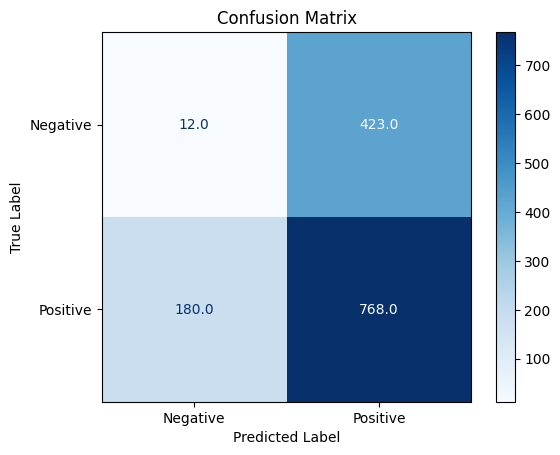

              precision    recall  f1-score   support

           0       0.06      0.03      0.04       435
           1       0.64      0.81      0.72       948

    accuracy                           0.56      1383
   macro avg       0.35      0.42      0.38      1383
weighted avg       0.46      0.56      0.50      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

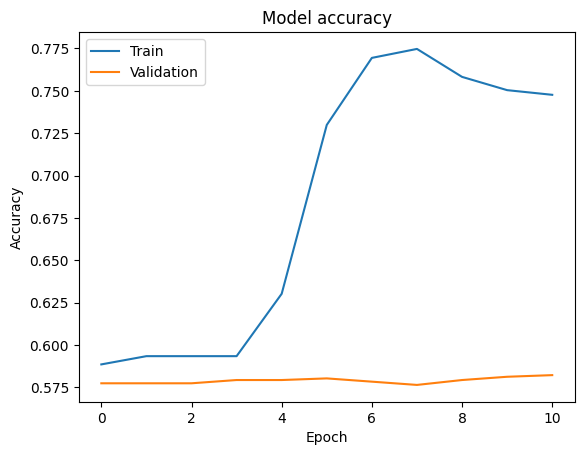

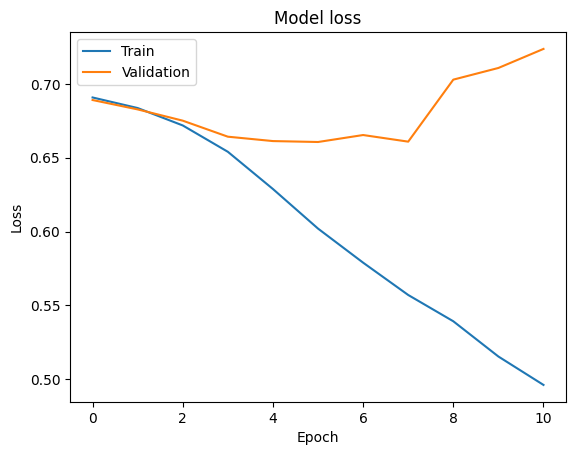

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# CNN with DT, 7 features (BEST)

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer
input_layer = Input(shape=(7, 1))

# Create the first block

block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=1)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
hist = model.fit(X_train, y_train, epochs=70, batch_size=64,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 2s 8ms/step - loss: 0.6897 - accuracy: 0.5935 - val_loss: 0.6881 - val_accuracy: 0.5775
Epoch 2/70
74/74 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5935 - val_loss: 0.6812 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5935 - val_loss: 0.6732 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 0s 5ms/step - loss: 0.6570 - accuracy: 0.5935 - val_loss: 0.6611 - val_accuracy: 0.5775
Epoch 5/70
74/74 [==============================] - 0s 5ms/step - loss: 0.6320 - accuracy: 0.6445 - val_loss: 0.6400 - val_accuracy: 0.5775
Epoch 6/70
74/74 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.7244 - val_loss: 0.6111 - val_accuracy: 0.5784
Epoch 7/70
74/74 [==============================] - 0s 5ms/step - loss: 0.5512 - accuracy: 0.7485 - val_loss: 0.5824 - val_accuracy: 0.5929
Epoch 8/70
74/74 [==

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.754880694143167
Recall: 0.7943037974683544
Precision: 0.8394648829431438
F1-score: 0.816260162601626


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

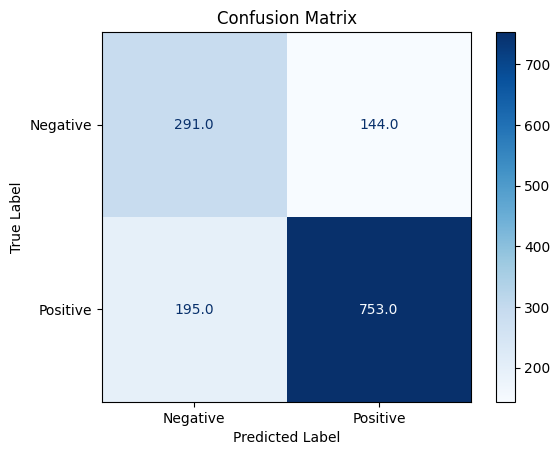

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       435
           1       0.84      0.79      0.82       948

    accuracy                           0.75      1383
   macro avg       0.72      0.73      0.72      1383
weighted avg       0.76      0.75      0.76      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

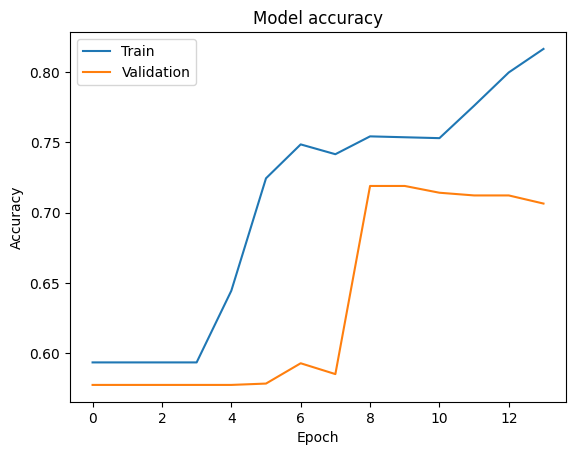

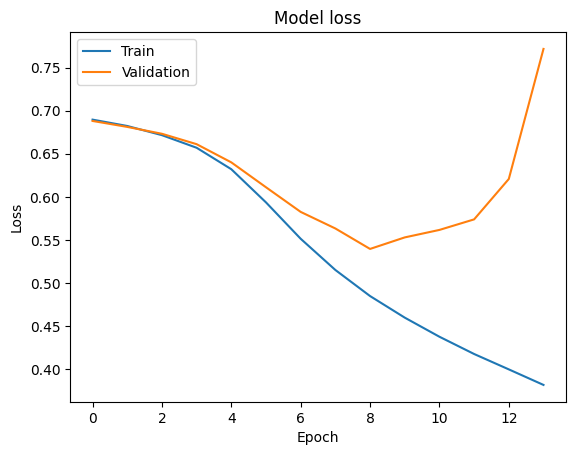

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




In [ ]:
model.save('/content/drive/MyDrive/GP-Data/CNN75.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# CNN with DT, 9 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer
input_layer = Input(shape=(9, 1))

# Create the first block

block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=1)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
hist = model.fit(X_train, y_train, epochs=70, batch_size=64,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 12ms/step - loss: 0.6888 - accuracy: 0.5905 - val_loss: 0.6855 - val_accuracy: 0.5775
Epoch 2/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6802 - accuracy: 0.5935 - val_loss: 0.6790 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.6722 - accuracy: 0.5935 - val_loss: 0.6749 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6617 - accuracy: 0.5935 - val_loss: 0.6669 - val_accuracy: 0.5775
Epoch 5/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6363 - accuracy: 0.6223 - val_loss: 0.6542 - val_accuracy: 0.5775
Epoch 6/70
74/74 [==============================] - 1s 7ms/step - loss: 0.5928 - accuracy: 0.7202 - val_loss: 0.6579 - val_accuracy: 0.5650
Epoch 7/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5480 - accuracy: 0.7422 - val_loss: 0.6697 - val_accuracy: 0.5765
Epoch 8/70
74/74 [=

Average Confusion Matrix:
44/44 [==============================] - 0s 3ms/step


<Figure size 800x600 with 0 Axes>

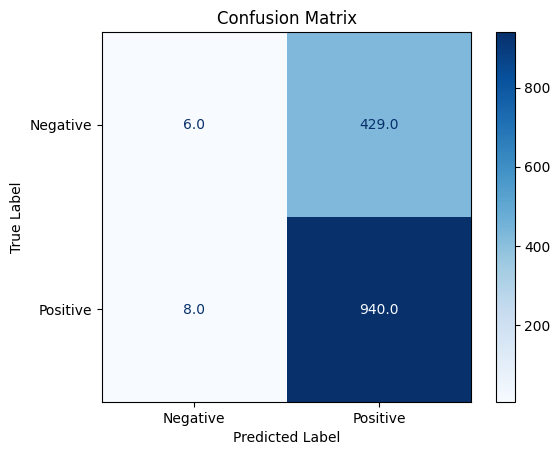

              precision    recall  f1-score   support

           0       0.43      0.01      0.03       435
           1       0.69      0.99      0.81       948

    accuracy                           0.68      1383
   macro avg       0.56      0.50      0.42      1383
weighted avg       0.61      0.68      0.56      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

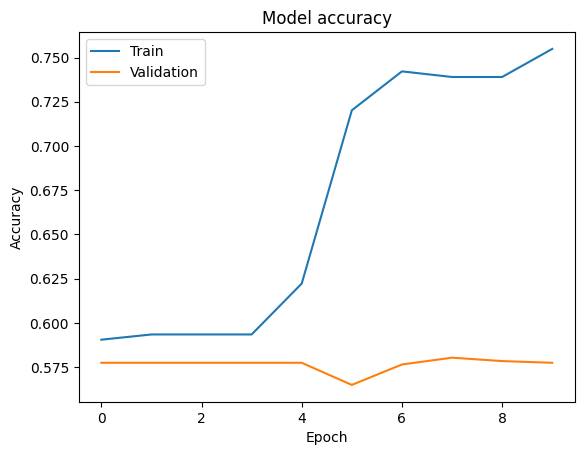

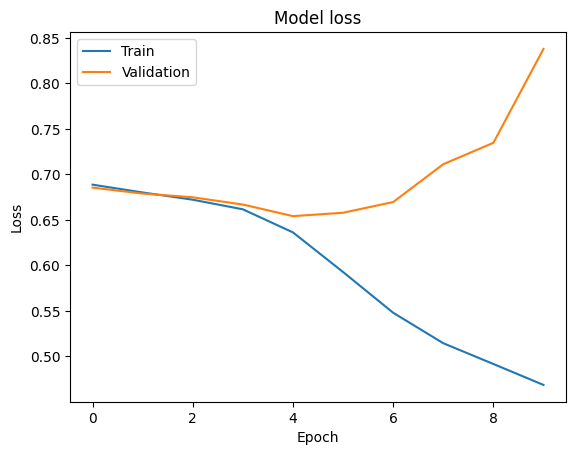

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




# Best model with 80, but the features unkown

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_testD)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.8590021691973969
Recall: 0.8006329113924051
Precision: 0.9921568627450981
F1-score: 0.8861646234676007


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

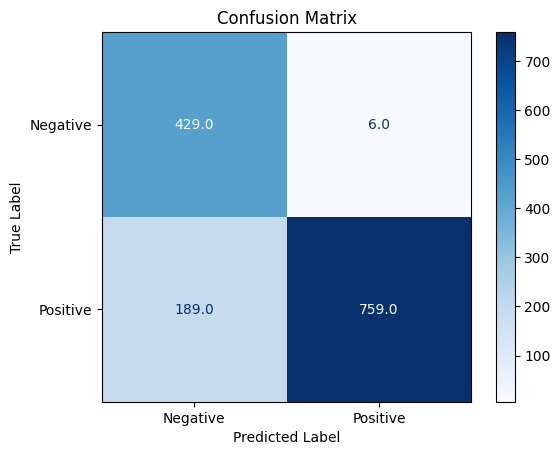

              precision    recall  f1-score   support

           0       0.69      0.99      0.81       435
           1       0.99      0.80      0.89       948

    accuracy                           0.86      1383
   macro avg       0.84      0.89      0.85      1383
weighted avg       0.90      0.86      0.86      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

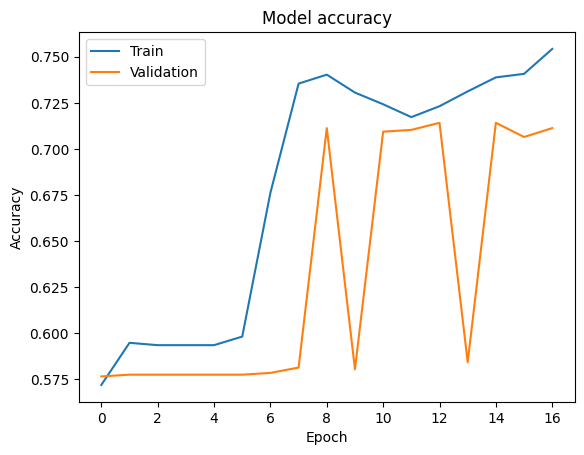

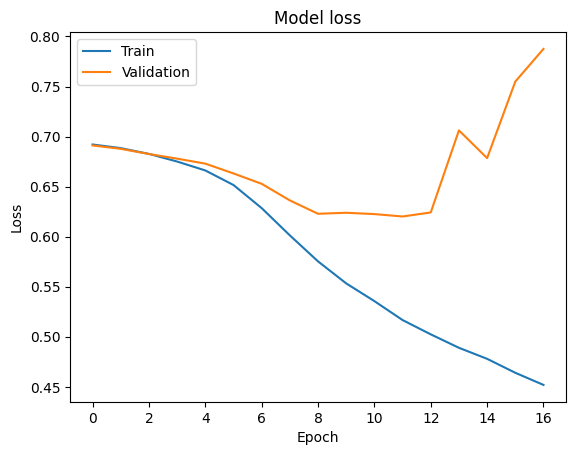

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/GP-Data/CNN80.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LSTM+DT, 5 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (5, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])



Epoch 1/30
37/37 [==============================] - 5s 40ms/step - loss: 0.6799 - accuracy: 0.5899 - val_loss: 0.6815 - val_accuracy: 0.5775
Epoch 2/30
37/37 [==============================] - 1s 20ms/step - loss: 0.6779 - accuracy: 0.5935 - val_loss: 0.6811 - val_accuracy: 0.5775
Epoch 3/30
37/37 [==============================] - 1s 20ms/step - loss: 0.6646 - accuracy: 0.5981 - val_loss: 0.6750 - val_accuracy: 0.7093
Epoch 4/30
37/37 [==============================] - 1s 19ms/step - loss: 0.6237 - accuracy: 0.6563 - val_loss: 0.5976 - val_accuracy: 0.7084
Epoch 5/30
37/37 [==============================] - 1s 19ms/step - loss: 0.5877 - accuracy: 0.6933 - val_loss: 0.6215 - val_accuracy: 0.7113
Epoch 6/30
37/37 [==============================] - 1s 20ms/step - loss: 0.5655 - accuracy: 0.7172 - val_loss: 0.6301 - val_accuracy: 0.5775
Epoch 7/30
37/37 [==============================] - 1s 23ms/step - loss: 0.4527 - accuracy: 0.7917 - val_loss: 0.9809 - val_accuracy: 0.5775
Epoch 8/30
37

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 5ms/step
Accuracy: 0.5755603759942155
Recall: 0.6909282700421941
Precision: 0.690200210748156
F1-score: 0.6905640484976279


Average Confusion Matrix:
44/44 [==============================] - 0s 5ms/step


<Figure size 800x600 with 0 Axes>

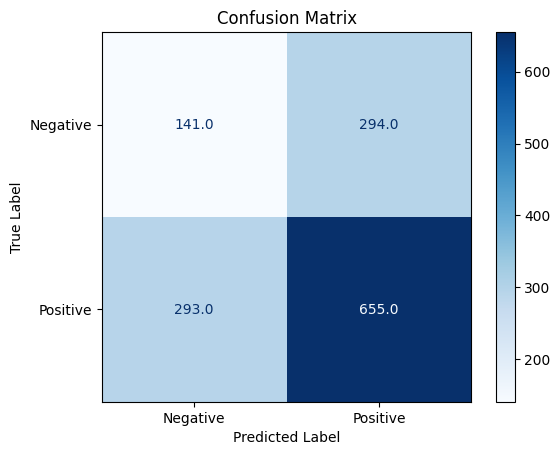

              precision    recall  f1-score   support

           0       0.32      0.32      0.32       435
           1       0.69      0.69      0.69       948

    accuracy                           0.58      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.58      0.58      0.58      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

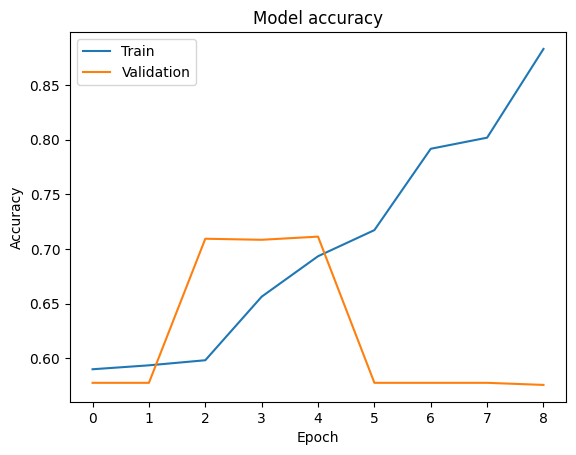

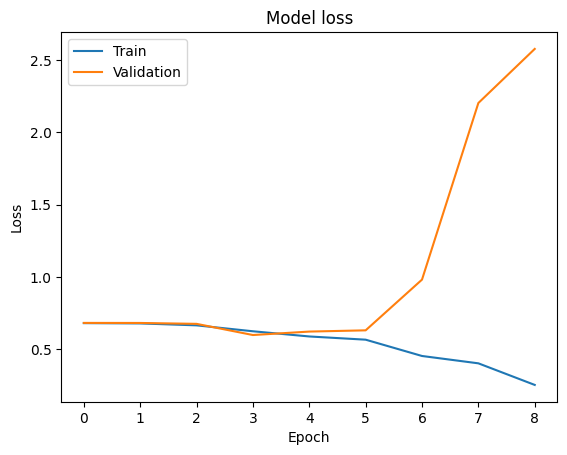

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# LSTM+DT, 7 features, (BEST)


Have same threshold value as CNN

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (7, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])



Epoch 1/30
37/37 [==============================] - 4s 38ms/step - loss: 0.6804 - accuracy: 0.5914 - val_loss: 0.6814 - val_accuracy: 0.5775
Epoch 2/30
37/37 [==============================] - 1s 21ms/step - loss: 0.6731 - accuracy: 0.5897 - val_loss: 0.6824 - val_accuracy: 0.5775
Epoch 3/30
37/37 [==============================] - 1s 21ms/step - loss: 0.6568 - accuracy: 0.5888 - val_loss: 0.6994 - val_accuracy: 0.5775
Epoch 4/30
37/37 [==============================] - 1s 21ms/step - loss: 0.6151 - accuracy: 0.6466 - val_loss: 0.6658 - val_accuracy: 0.7036
Epoch 5/30
37/37 [==============================] - 1s 22ms/step - loss: 0.5944 - accuracy: 0.6880 - val_loss: 0.6990 - val_accuracy: 0.7016
Epoch 6/30
37/37 [==============================] - 1s 20ms/step - loss: 0.6311 - accuracy: 0.6510 - val_loss: 0.7606 - val_accuracy: 0.5746
Epoch 7/30
37/37 [==============================] - 1s 21ms/step - loss: 0.5333 - accuracy: 0.7242 - val_loss: 0.6696 - val_accuracy: 0.5804
Epoch 8/30
37

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 4ms/step
Accuracy: 0.589298626174982
Recall: 0.7172995780590717
Precision: 0.6938775510204082
F1-score: 0.7053941908713692


Average Confusion Matrix:
44/44 [==============================] - 0s 5ms/step


<Figure size 800x600 with 0 Axes>

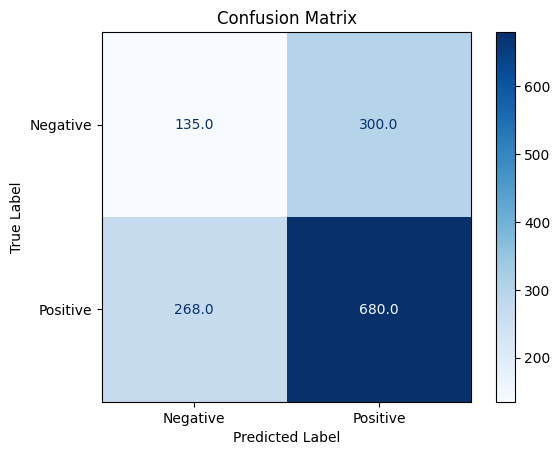

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       435
           1       0.69      0.72      0.71       948

    accuracy                           0.59      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.58      0.59      0.58      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

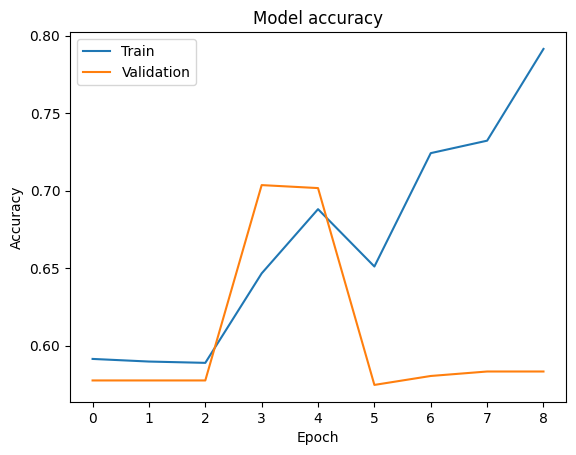

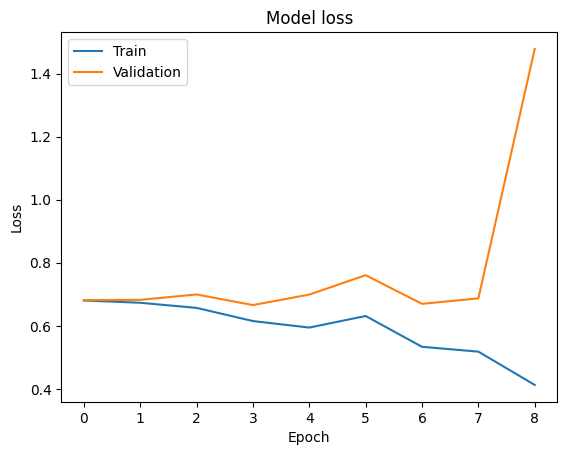

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# LSTM+DT, 9 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (9, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])



Epoch 1/30
37/37 [==============================] - 5s 50ms/step - loss: 0.6800 - accuracy: 0.5882 - val_loss: 0.6856 - val_accuracy: 0.5775
Epoch 2/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6764 - accuracy: 0.5935 - val_loss: 0.6811 - val_accuracy: 0.5775
Epoch 3/30
37/37 [==============================] - 1s 33ms/step - loss: 0.6761 - accuracy: 0.5935 - val_loss: 0.6810 - val_accuracy: 0.5775
Epoch 4/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6768 - accuracy: 0.5935 - val_loss: 0.6839 - val_accuracy: 0.5775
Epoch 5/30
37/37 [==============================] - 1s 33ms/step - loss: 0.6764 - accuracy: 0.5935 - val_loss: 0.6812 - val_accuracy: 0.5775
Epoch 6/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6720 - accuracy: 0.5935 - val_loss: 0.6884 - val_accuracy: 0.5775
Epoch 7/30
37/37 [==============================] - 1s 34ms/step - loss: 0.6562 - accuracy: 0.5914 - val_loss: 0.6871 - val_accuracy: 0.5765
Epoch 8/30
37

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 6ms/step
Accuracy: 0.38322487346348516
Recall: 0.3670886075949367
Precision: 0.5790349417637272
F1-score: 0.4493221433182698


Average Confusion Matrix:
44/44 [==============================] - 0s 6ms/step


<Figure size 800x600 with 0 Axes>

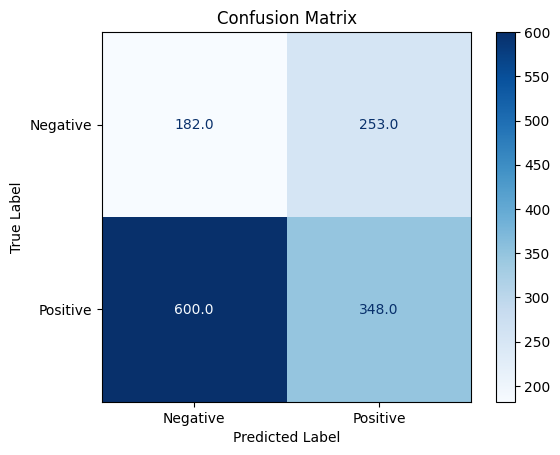

              precision    recall  f1-score   support

           0       0.23      0.42      0.30       435
           1       0.58      0.37      0.45       948

    accuracy                           0.38      1383
   macro avg       0.41      0.39      0.37      1383
weighted avg       0.47      0.38      0.40      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

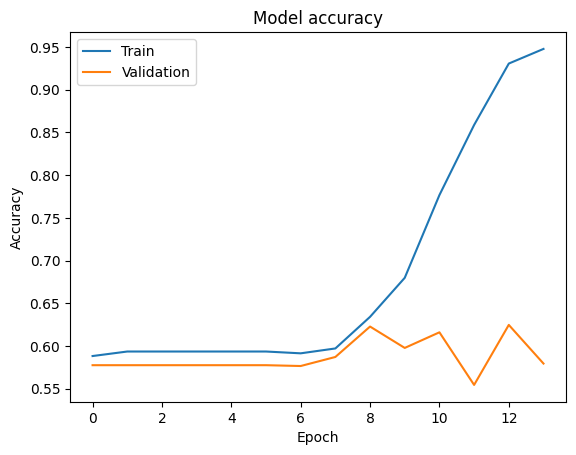

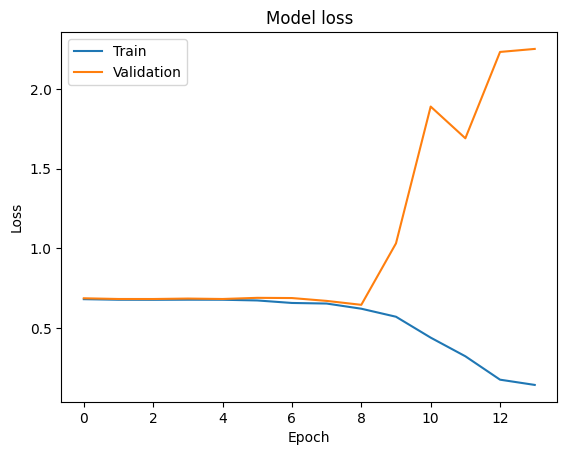

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+LSTM+DT, 5 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy')

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(5, 1))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(64)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 11ms/step - loss: 0.6751 - accuracy: 0.5918 - val_loss: 0.6787 - val_accuracy: 0.5746
Epoch 2/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.6430 - val_loss: 0.6386 - val_accuracy: 0.5784
Epoch 3/70
74/74 [==============================] - 0s 5ms/step - loss: 0.5662 - accuracy: 0.6880 - val_loss: 0.6215 - val_accuracy: 0.5823
Epoch 4/70
74/74 [==============================] - 0s 6ms/step - loss: 0.5448 - accuracy: 0.7263 - val_loss: 0.6898 - val_accuracy: 0.5881
Epoch 5/70
74/74 [==============================] - 0s 6ms/step - loss: 0.5179 - accuracy: 0.7494 - val_loss: 0.7171 - val_accuracy: 0.5784
Epoch 6/70
74/74 [==============================] - 0s 6ms/step - loss: 0.4682 - accuracy: 0.8050 - val_loss: 0.7702 - val_accuracy: 0.7113
Epoch 7/70
74/74 [==============================] - 0s 6ms/step - loss: 0.3896 - accuracy: 0.8479 - val_loss: 1.2944 - val_accuracy: 0.5861
Epoch 8/70
74/74 [=

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.6688358640636298
Recall: 0.8280590717299579
Precision: 0.7268518518518519
F1-score: 0.7741617357001972


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

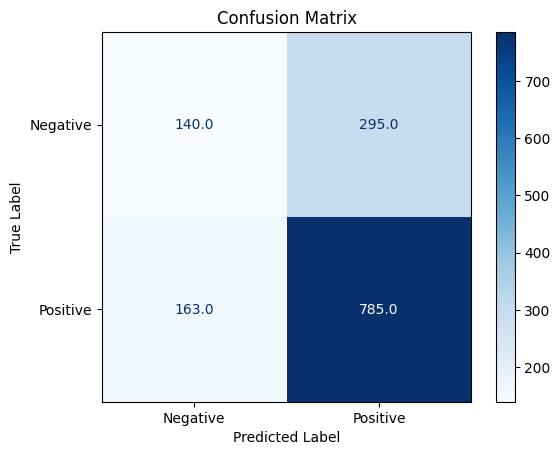

              precision    recall  f1-score   support

           0       0.46      0.32      0.38       435
           1       0.73      0.83      0.77       948

    accuracy                           0.67      1383
   macro avg       0.59      0.57      0.58      1383
weighted avg       0.64      0.67      0.65      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

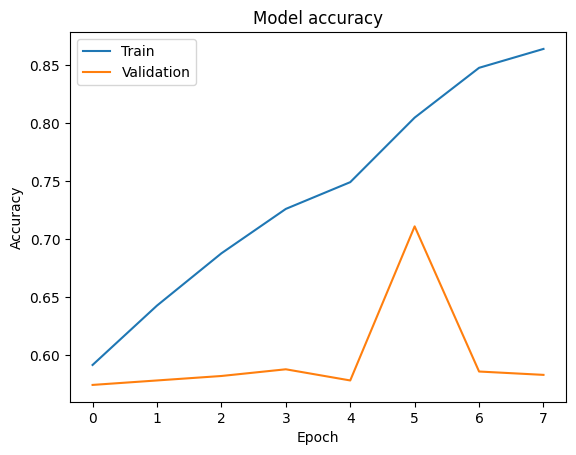

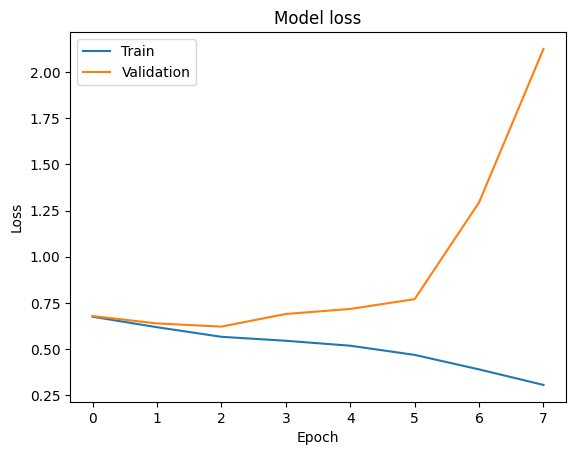

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+LSTM+DT, 7 features (BEST)

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy')

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(7, 1))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(64)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 14ms/step - loss: 0.6701 - accuracy: 0.5918 - val_loss: 0.6733 - val_accuracy: 0.5756
Epoch 2/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5659 - accuracy: 0.7191 - val_loss: 0.5823 - val_accuracy: 0.7161
Epoch 3/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5035 - accuracy: 0.7527 - val_loss: 0.5679 - val_accuracy: 0.8402
Epoch 4/70
74/74 [==============================] - 1s 8ms/step - loss: 0.4857 - accuracy: 0.7849 - val_loss: 0.5950 - val_accuracy: 0.7103
Epoch 5/70
74/74 [==============================] - 1s 8ms/step - loss: 0.4742 - accuracy: 0.7813 - val_loss: 0.6059 - val_accuracy: 0.7113
Epoch 6/70
74/74 [==============================] - 1s 8ms/step - loss: 0.4483 - accuracy: 0.7883 - val_loss: 0.6216 - val_accuracy: 0.8402
Epoch 7/70
74/74 [==============================] - 1s 8ms/step - loss: 0.4351 - accuracy: 0.7686 - val_loss: 0.7396 - val_accuracy: 0.5775
Epoch 8/70
74/74 [=

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.8785249457700651
Recall: 0.8417721518987342
Precision: 0.9779411764705882
F1-score: 0.9047619047619048


Average Confusion Matrix:
44/44 [==============================] - 0s 3ms/step


<Figure size 800x600 with 0 Axes>

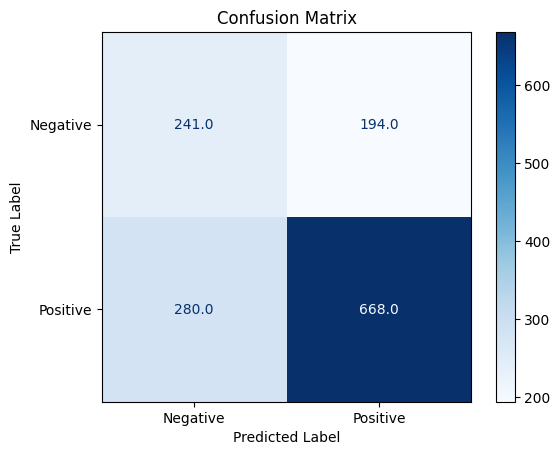

              precision    recall  f1-score   support

           0       0.46      0.55      0.50       435
           1       0.77      0.70      0.74       948

    accuracy                           0.66      1383
   macro avg       0.62      0.63      0.62      1383
weighted avg       0.68      0.66      0.66      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

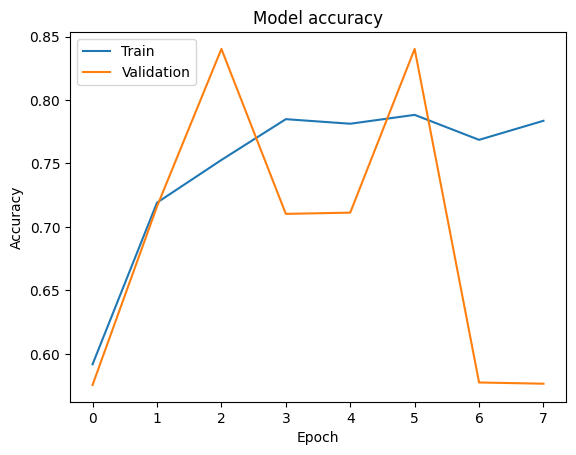

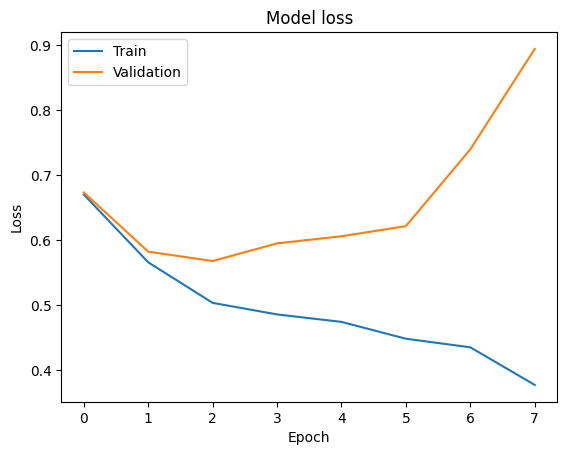

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+LSTM+DT, 9

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy')

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(9, 1))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(64)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 15ms/step - loss: 0.6788 - accuracy: 0.5905 - val_loss: 0.6808 - val_accuracy: 0.5756
Epoch 2/70
74/74 [==============================] - 1s 9ms/step - loss: 0.6713 - accuracy: 0.5890 - val_loss: 0.6768 - val_accuracy: 0.5727
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.6604 - accuracy: 0.5861 - val_loss: 0.6805 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 1s 9ms/step - loss: 0.6433 - accuracy: 0.5952 - val_loss: 0.6643 - val_accuracy: 0.5669
Epoch 5/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5928 - accuracy: 0.6815 - val_loss: 0.7197 - val_accuracy: 0.5525
Epoch 6/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5481 - accuracy: 0.7200 - val_loss: 0.7387 - val_accuracy: 0.5650
Epoch 7/70
74/74 [==============================] - 1s 9ms/step - loss: 0.4853 - accuracy: 0.7695 - val_loss: 1.1048 - val_accuracy: 0.5669
Epoch 8/70
74/74 [=

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 3ms/step
Accuracy: 0.6406362979031092
Recall: 0.9261603375527426
Precision: 0.6727969348659004
F1-score: 0.7794052374611629


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

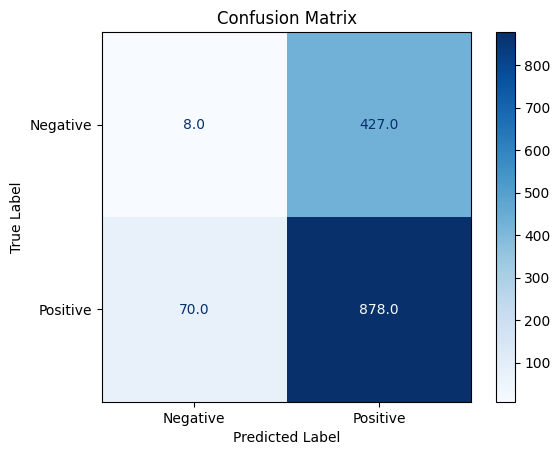

              precision    recall  f1-score   support

           0       0.10      0.02      0.03       435
           1       0.67      0.93      0.78       948

    accuracy                           0.64      1383
   macro avg       0.39      0.47      0.41      1383
weighted avg       0.49      0.64      0.54      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

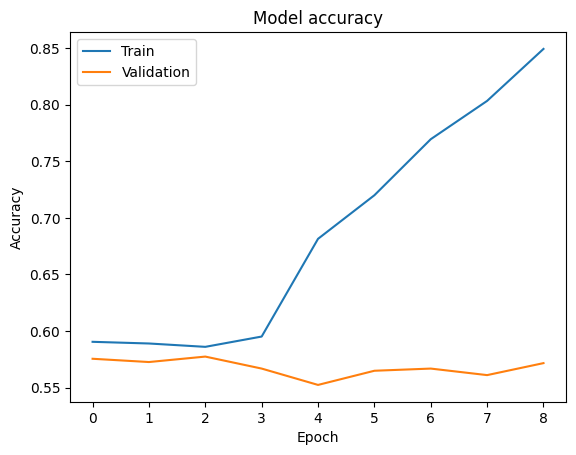

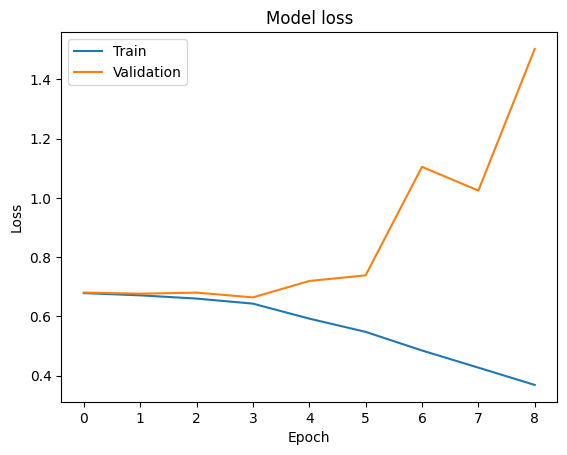

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+GRU+DT 5 features, (BEST)




In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy')

Have same threshold value as CNN+LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(5, 1))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/70
74/74 [==============================] - 10s 31ms/step - loss: 0.6532 - accuracy: 0.6170 - val_loss: 0.6209 - val_accuracy: 0.5833
Epoch 2/70
74/74 [==============================] - 1s 12ms/step - loss: 0.5287 - accuracy: 0.7324 - val_loss: 1.1759 - val_accuracy: 0.5804
Epoch 3/70
74/74 [==============================] - 1s 12ms/step - loss: 0.3687 - accuracy: 0.8198 - val_loss: 2.0696 - val_accuracy: 0.5813
Epoch 4/70
74/74 [==============================] - 1s 13ms/step - loss: 0.1778 - accuracy: 0.9213 - val_loss: 2.7634 - val_accuracy: 0.5775
Epoch 5/70
74/74 [==============================] - 1s 12ms/step - loss: 0.1434 - accuracy: 0.9391 - val_loss: 2.7201 - val_accuracy: 0.5794
Epoch 6/70
74/74 [==============================] - 1s 12ms/step - loss: 0.0537 - accuracy: 0.9714 - val_loss: 3.1820 - val_accuracy: 0.5804


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 5ms/step
Accuracy: 0.5755603759942155
Recall: 0.6877637130801688
Precision: 0.6914103923647932
F1-score: 0.6895822316234796


Average Confusion Matrix:
44/44 [==============================] - 0s 5ms/step


<Figure size 800x600 with 0 Axes>

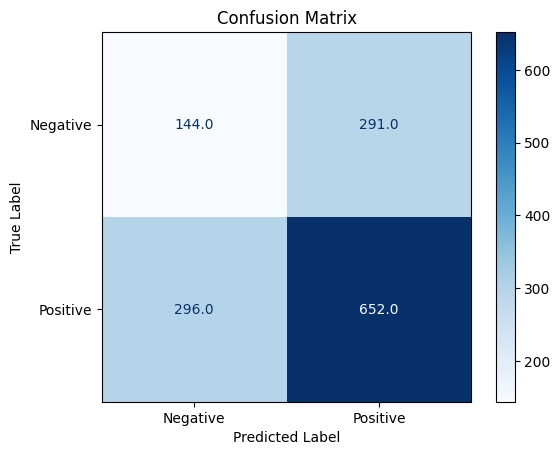

              precision    recall  f1-score   support

           0       0.33      0.33      0.33       435
           1       0.69      0.69      0.69       948

    accuracy                           0.58      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.58      0.58      0.58      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

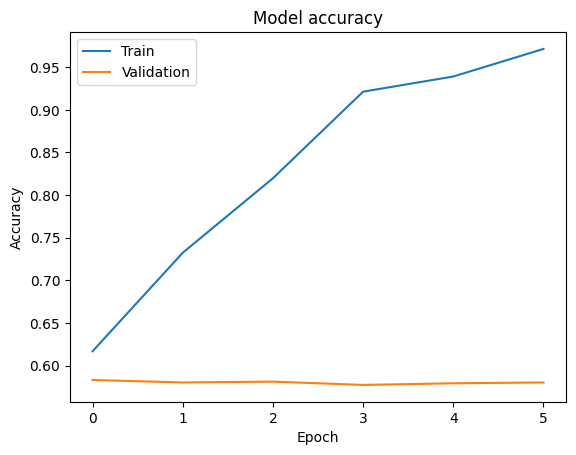

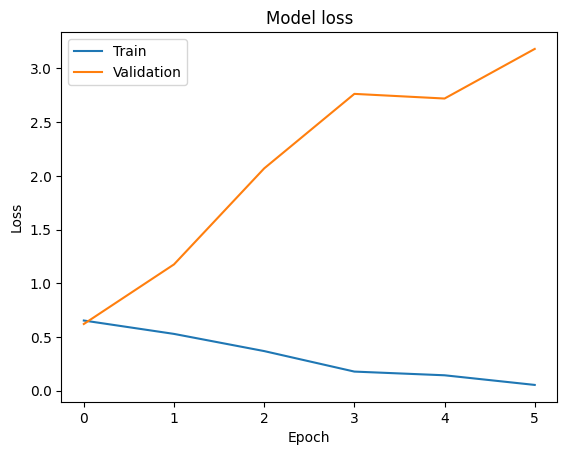

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+GRU+DT 7 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(7, 1))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/70
74/74 [==============================] - 10s 31ms/step - loss: 0.6395 - accuracy: 0.6244 - val_loss: 0.4934 - val_accuracy: 0.8354
Epoch 2/70
74/74 [==============================] - 1s 13ms/step - loss: 0.4439 - accuracy: 0.7786 - val_loss: 0.9762 - val_accuracy: 0.5871
Epoch 3/70
74/74 [==============================] - 1s 13ms/step - loss: 0.3019 - accuracy: 0.8642 - val_loss: 1.4918 - val_accuracy: 0.7103
Epoch 4/70
74/74 [==============================] - 1s 13ms/step - loss: 0.2346 - accuracy: 0.8955 - val_loss: 2.1170 - val_accuracy: 0.5813
Epoch 5/70
74/74 [==============================] - 1s 13ms/step - loss: 0.1727 - accuracy: 0.9211 - val_loss: 2.3361 - val_accuracy: 0.5910
Epoch 6/70
74/74 [==============================] - 1s 13ms/step - loss: 0.0708 - accuracy: 0.9670 - val_loss: 2.9125 - val_accuracy: 0.5852


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 5ms/step
Accuracy: 0.603759942154736
Recall: 0.4229957805907173
Precision: 0.9975124378109452
F1-score: 0.5940740740740741


Average Confusion Matrix:
44/44 [==============================] - 0s 5ms/step


<Figure size 800x600 with 0 Axes>

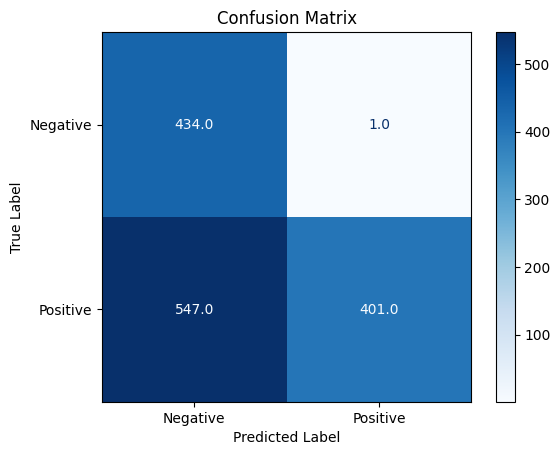

              precision    recall  f1-score   support

           0       0.44      1.00      0.61       435
           1       1.00      0.42      0.59       948

    accuracy                           0.60      1383
   macro avg       0.72      0.71      0.60      1383
weighted avg       0.82      0.60      0.60      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

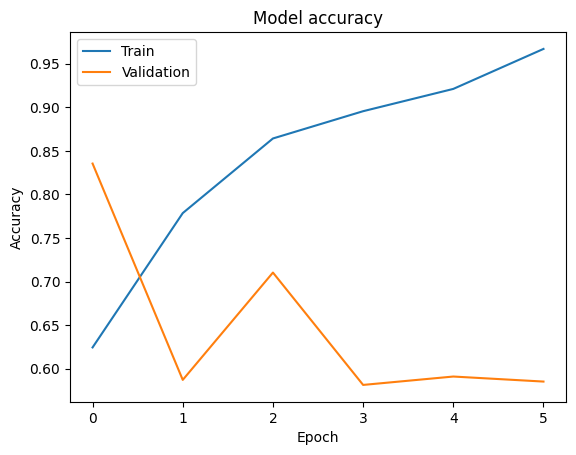

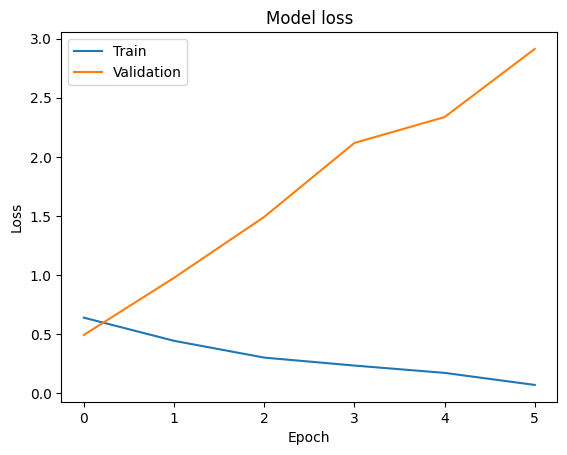

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+GRU+DT 9 features

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(9, 1))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/70
74/74 [==============================] - 9s 33ms/step - loss: 0.6762 - accuracy: 0.5926 - val_loss: 0.6763 - val_accuracy: 0.5775
Epoch 2/70
74/74 [==============================] - 1s 16ms/step - loss: 0.5828 - accuracy: 0.6802 - val_loss: 1.0416 - val_accuracy: 0.5765
Epoch 3/70
74/74 [==============================] - 1s 16ms/step - loss: 0.4635 - accuracy: 0.7650 - val_loss: 1.4454 - val_accuracy: 0.5794
Epoch 4/70
74/74 [==============================] - 1s 16ms/step - loss: 0.3163 - accuracy: 0.8625 - val_loss: 1.6684 - val_accuracy: 0.5756
Epoch 5/70
74/74 [==============================] - 1s 15ms/step - loss: 0.2328 - accuracy: 0.8953 - val_loss: 1.8176 - val_accuracy: 0.5775
Epoch 6/70
74/74 [==============================] - 1s 16ms/step - loss: 0.1710 - accuracy: 0.9220 - val_loss: 2.4512 - val_accuracy: 0.5842


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 5ms/step
Accuracy: 0.6854663774403471
Recall: 1.0
Precision: 0.6854663774403471
F1-score: 0.8133848133848134


Average Confusion Matrix:
44/44 [==============================] - 0s 5ms/step


<Figure size 800x600 with 0 Axes>

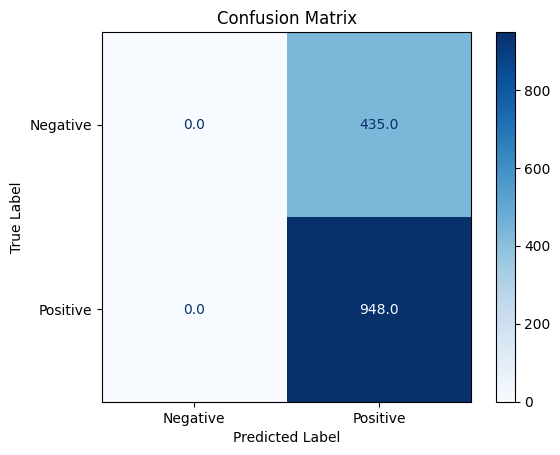

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       435
           1       0.69      1.00      0.81       948

    accuracy                           0.69      1383
   macro avg       0.34      0.50      0.41      1383
weighted avg       0.47      0.69      0.56      1383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

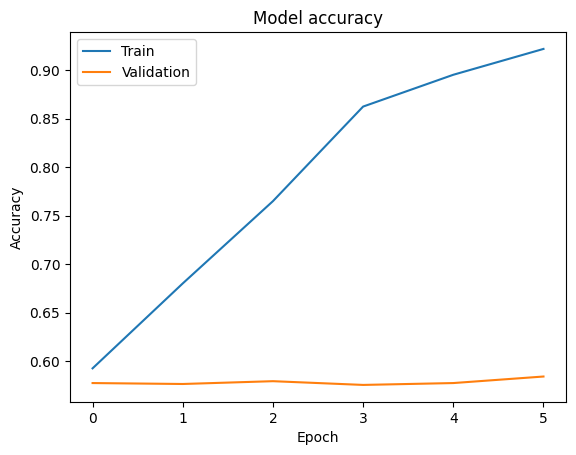

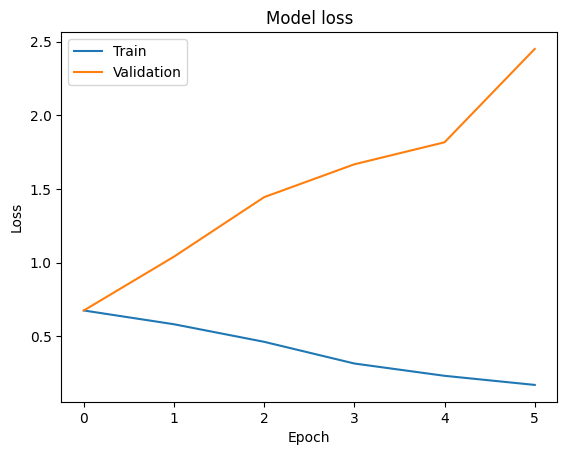

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# RNN+DT, 5f (BEST)

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train5.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate5.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test5.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train5.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate5.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test5.npy')

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

input_shape = (5, 1)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
model = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 2s 11ms/step - loss: 0.6697 - accuracy: 0.5969 - val_loss: 0.6670 - val_accuracy: 0.5736
Epoch 2/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6251 - accuracy: 0.7126 - val_loss: 0.6508 - val_accuracy: 0.5784
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5899 - accuracy: 0.7058 - val_loss: 0.6264 - val_accuracy: 0.5861
Epoch 4/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5706 - accuracy: 0.7022 - val_loss: 0.6740 - val_accuracy: 0.5756
Epoch 5/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5529 - accuracy: 0.7113 - val_loss: 0.6631 - val_accuracy: 0.5842
Epoch 6/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5340 - accuracy: 0.7149 - val_loss: 0.6709 - val_accuracy: 0.5804


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.7744034707158352
Recall: 0.8354430379746836
Precision: 0.8354430379746836
F1-score: 0.8354430379746836


Average Confusion Matrix:
44/44 [==============================] - 0s 3ms/step


<Figure size 800x600 with 0 Axes>

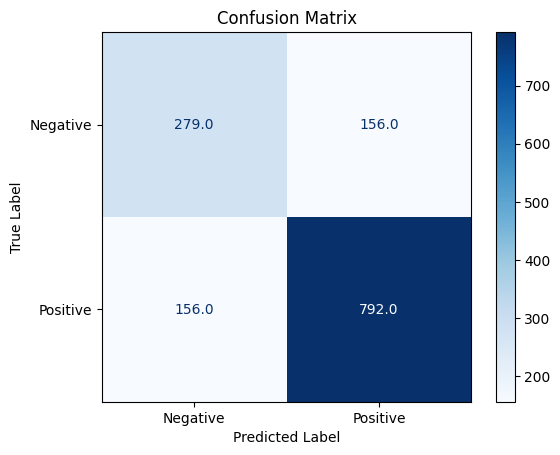

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       435
           1       0.84      0.84      0.84       948

    accuracy                           0.77      1383
   macro avg       0.74      0.74      0.74      1383
weighted avg       0.77      0.77      0.77      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

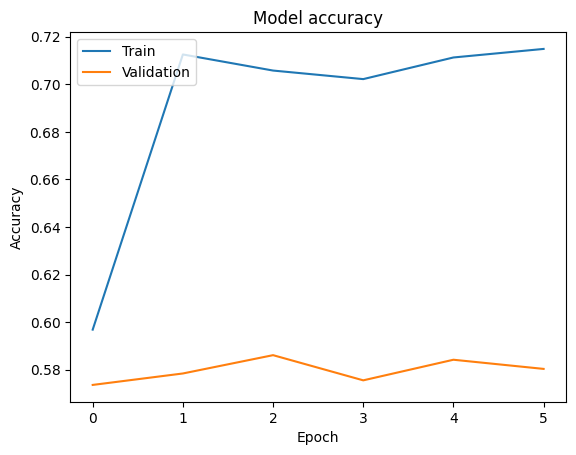

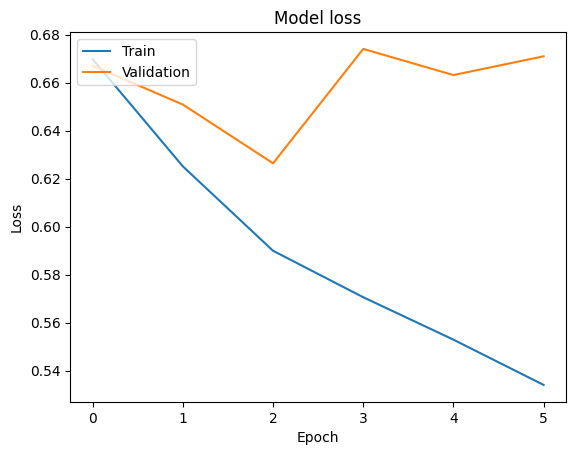

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/RNN77.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# RNN+DT,7f

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test7.npy')

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

input_shape = (7, 1)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
model = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 13ms/step - loss: 0.6533 - accuracy: 0.6193 - val_loss: 0.6386 - val_accuracy: 0.5842
Epoch 2/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5635 - accuracy: 0.7221 - val_loss: 0.5469 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5007 - accuracy: 0.7409 - val_loss: 0.5662 - val_accuracy: 0.5813
Epoch 4/70
74/74 [==============================] - 1s 9ms/step - loss: 0.4608 - accuracy: 0.7426 - val_loss: 0.6285 - val_accuracy: 0.5813
Epoch 5/70
74/74 [==============================] - 1s 9ms/step - loss: 0.4218 - accuracy: 0.7802 - val_loss: 0.7284 - val_accuracy: 0.5775


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.6724511930585684
Recall: 0.8291139240506329
Precision: 0.7298050139275766
F1-score: 0.7762962962962962


Average Confusion Matrix:
44/44 [==============================] - 0s 4ms/step


<Figure size 800x600 with 0 Axes>

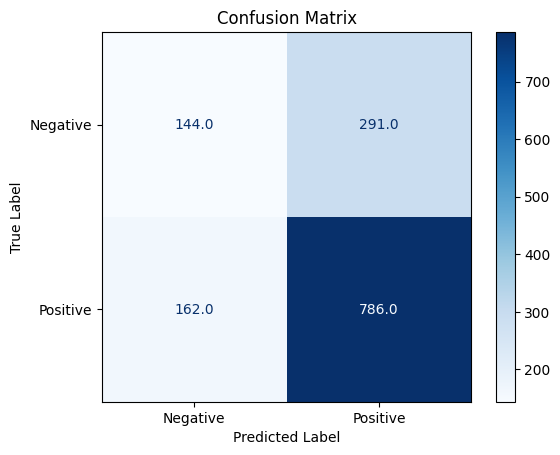

              precision    recall  f1-score   support

           0       0.47      0.33      0.39       435
           1       0.73      0.83      0.78       948

    accuracy                           0.67      1383
   macro avg       0.60      0.58      0.58      1383
weighted avg       0.65      0.67      0.65      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

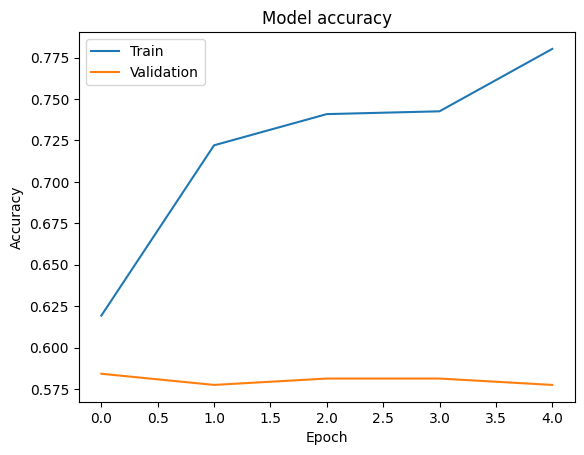

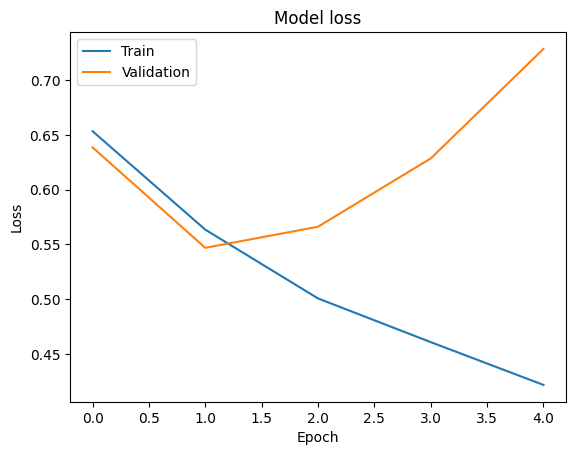

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# RNN+DT,9f

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_train9.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_validate9.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/X_test9.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_train9.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_validate9.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/DT_Dataset/y_test9.npy')

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

input_shape = (9, 1)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
model = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 2s 13ms/step - loss: 0.6780 - accuracy: 0.5713 - val_loss: 0.6726 - val_accuracy: 0.5727
Epoch 2/70
74/74 [==============================] - 1s 10ms/step - loss: 0.6367 - accuracy: 0.6326 - val_loss: 0.6541 - val_accuracy: 0.5698
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5988 - accuracy: 0.6925 - val_loss: 0.6610 - val_accuracy: 0.5688
Epoch 4/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5656 - accuracy: 0.7069 - val_loss: 0.6566 - val_accuracy: 0.5842
Epoch 5/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5420 - accuracy: 0.7170 - val_loss: 0.6891 - val_accuracy: 0.5775


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 4ms/step
Accuracy: 0.6804049168474331
Recall: 0.9715189873417721
Precision: 0.6893712574850299
F1-score: 0.8064798598949211


Average Confusion Matrix:
44/44 [==============================] - 0s 4ms/step


<Figure size 800x600 with 0 Axes>

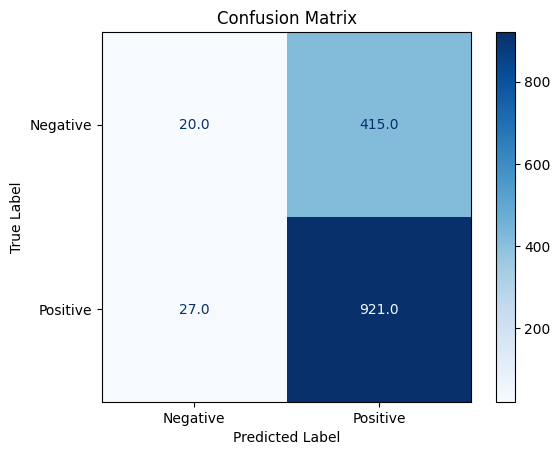

              precision    recall  f1-score   support

           0       0.43      0.05      0.08       435
           1       0.69      0.97      0.81       948

    accuracy                           0.68      1383
   macro avg       0.56      0.51      0.44      1383
weighted avg       0.61      0.68      0.58      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

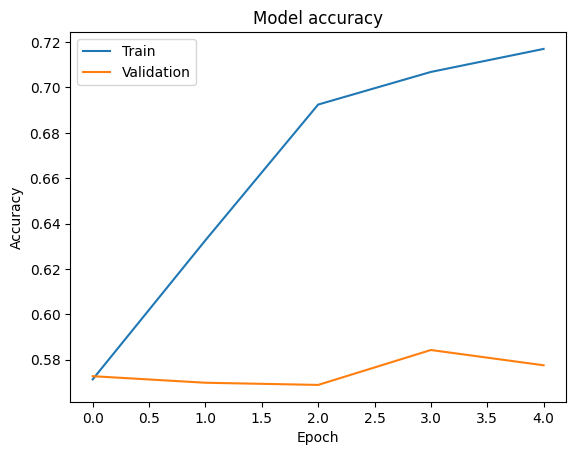

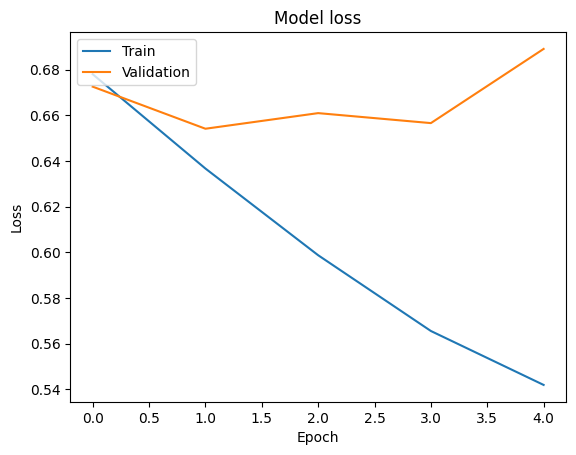

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
